# Adapt respiration functions to reliably evaluate Equivital recordings
Musicians and not musicians.

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import heartpy as hp
import pingouin as pg

from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
%load_ext autoreload
%autoreload 1
%aimport qex
%aimport al
%aimport eq
%aimport rp
%aimport rp2
%aimport mh

In [964]:
%reload_ext autoreload

In [4]:
data_loc = './demodata/'
demofiles = os.listdir(data_loc)
plot_loc = './plots/'
mydpi = 196

# Testing outputs
Initial adaptation of the respy parameters oriented towards the EQ measurements using multisensor recordings from several musicians during a piece that alternates playing and tacet (listening). 

From Lydo 2023, measurements from Arban's Carnival of Venise (Arba) during the first concert of the series (C1). Measurements all in the demodata folder.

In [7]:
musicians = ['LS410','VN102','VN206','BR601','BR603','WW505']
# Bass, Concert master, Second violin, Tuba, French horn, Flute

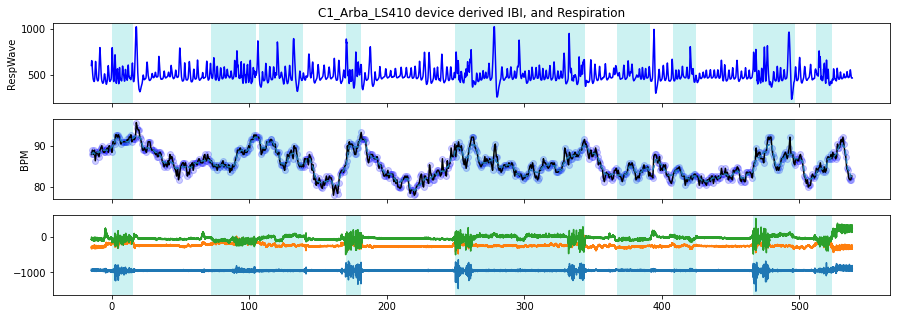

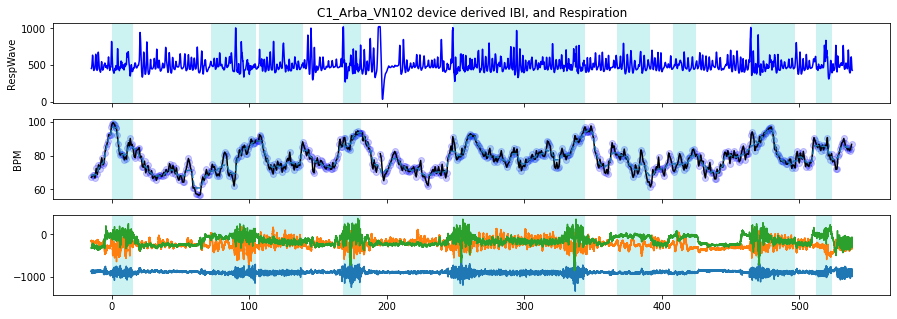

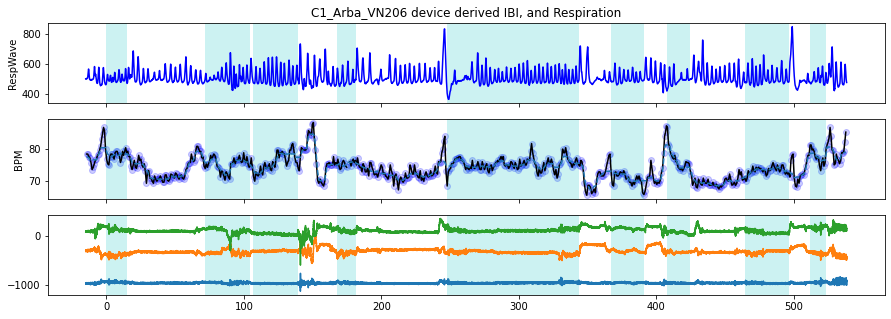

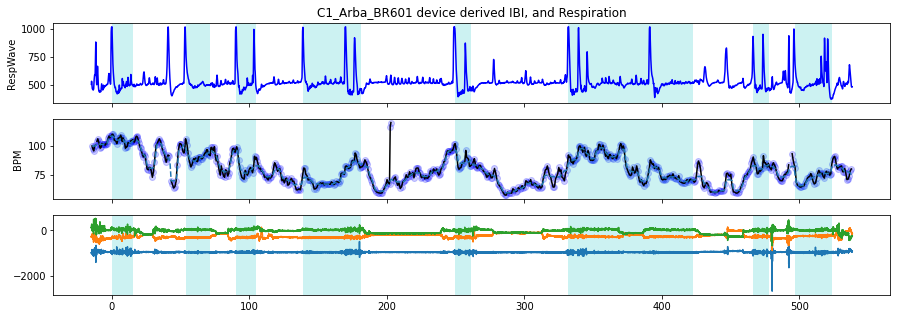

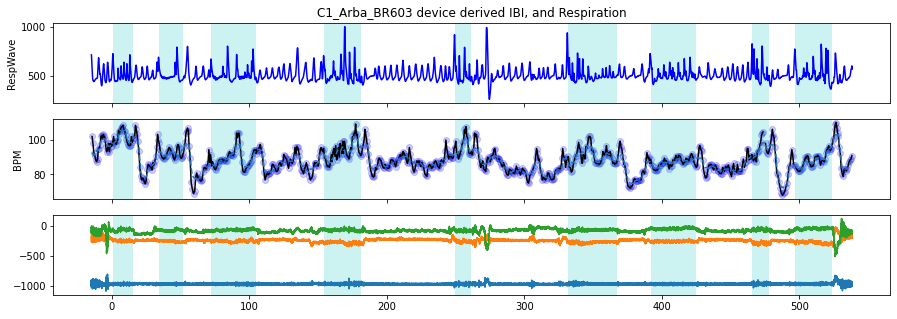

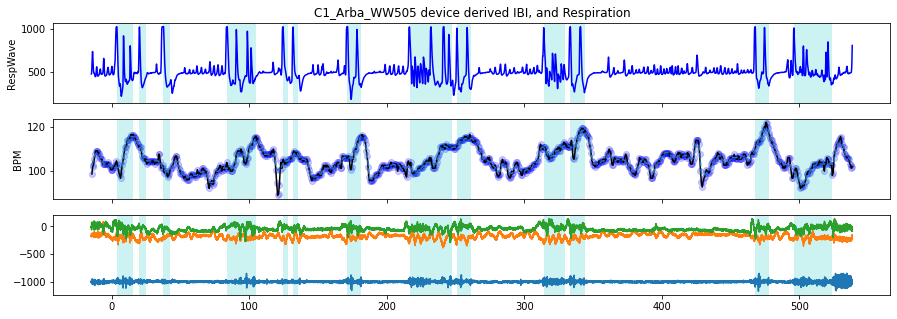

In [8]:
piece='Arba'
concert = 'C1'
for partID in musicians:
    sig_ex = '_'.join([concert,piece,partID])

    Score_map = pd.read_csv(data_loc+'PlayTimings - Score_parts.csv',index_col = 0)
    Pentries = pd.read_csv(data_loc+'PlayTimings_'+piece+'_entries.csv') 
    part = Score_map.loc[partID,piece]

    V = pd.read_csv(data_loc + sig_ex+'_EQCIBI.csv', index_col = 0)
    IBI=mh.clean_IBI(V['p_sTime'],V['Interbeat Interval (MS)'],activitytype='default')
    beatfeats = mh.ibi_beatfeats(IBI.index,IBI.IBI.values)
    V = pd.read_csv(data_loc + sig_ex+'_EQBACC.csv', index_col = 0)
    sig_t = V['p_sTime']
    sig_v = np.sqrt(np.square(V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']].diff()).sum(axis=1))

    R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)

    fig, (ax) = plt.subplots(3, 1,figsize = [15,5],sharex = True)
    ax[0].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
    ax[0].set_xlabel('Time (s), piece')
    ax[0].set_ylabel('RespWave')
    ax[0].set_title(sig_ex +' device derived IBI, and Respiration')
    ax[1].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='cleaned')
    beatfeats['HR1bt'].plot(ax=ax[1],color='k')
    beatfeats['HR10bt'].plot(ax=ax[1],style='--')
    ax[1].set_ylabel('BPM')

    ax[2].plot(V['p_sTime'],V[[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']])


    for j in range(len(ax)): eq.play_shade(ax[j],Pentries,concert,part)
    plt.savefig(plot_loc+'_'.join([sig_ex,'Cardio','Resp'])+'.png',dpi=mydpi)
    plt.show()

The respiration waves for these six musicians show different types of performance breathing activity and interactions with other gestures of playing. 

The respiration waves as captured by the equivital vest also have the complication of showing adaptation to the recent respiratory range, with specific values shifting their meaning relative to chest circumpherence over time. As such, interpretation of these waves shapes is bit different from the single respiration belts (during quiet listening) that formed the basis of the respy algorithmes for respiratory phase detection.

The following sections will show the current respy performance on phase detections and demonstrate adaptations required to reliably assess respiratory phases in musicians while they performed. 

Some necessary adaptations include categorising the type of playing (instrument) and restrategising the evaluation of noise in these sequences. 

Modifications will be saved in function file rp2.py

Note also that these EQRESP measurements are always recorded at 25.6 Hz, a practical constraint on the precision of phases evaluated relative to other signals. 

# RESPY on second violin

In [575]:
partID = 'VN206'
sig_ex = '_'.join([concert,piece,partID])
piece='Arba'
concert = 'C1'
Score_map = pd.read_csv(data_loc+'PlayTimings - Score_parts.csv',index_col = 0)
Pentries = pd.read_csv(data_loc+'PlayTimings_'+piece+'_entries.csv') 
part = Score_map.loc[partID,piece]

R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)
R.set_index('p_sTime',drop=True,inplace=True)
Breaths = rp.Inspiration_Extract(R['Breathing'])  
# rp.Breath_Features(R['Breathing'],scalingfactor=1,filtered=False)

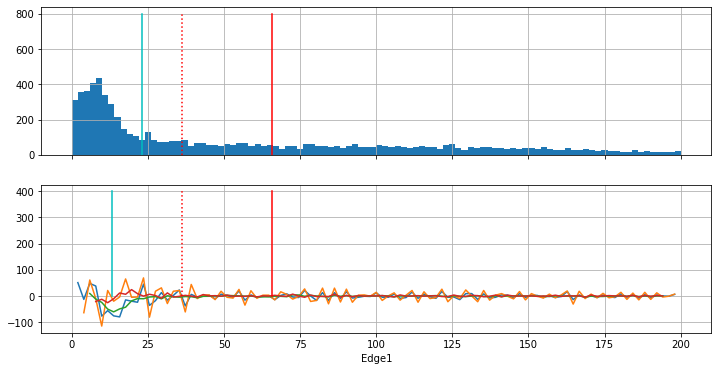

[96.81541428851173, 37.249182812740656, 23.03516102113721, 13.16294915493555]


In [579]:
sf = 25.6
newResp = R.loc[:,['Breathing']].copy()
newResp['Filt'] = rp2.respnormed(R['Breathing'],scaling=1)
newResp['Diff1'] = rp2.diffed(newResp['Filt'] )
expansion_dist = newResp['Diff1'].loc[newResp['Diff1']>0].copy()*sf
fig, axes = plt.subplots(2,1,figsize=(12,6),sharex = True)
ax = axes[0]
expansion_dist.hist(bins=100,range=[0,200],ax=ax)
ax.plot(np.array([1,1])*expansion_dist.mean(),[0,800],'r')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.55,[0,800],'r',linestyle=':')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.35,[0,800],'c')
# InspThresh = newResp['Diff1'].loc[newResp['Diff1']>0].mean()*sf*vel_c
# VelThresh = InspThresh/sf;
ax = axes[1]
h = np.histogram(expansion_dist,bins=int(4*sf),range=[0,200])
dist = pd.DataFrame(columns =['Counts','Edge1','Edge2'])
dist['Edge1'] = h[1][:-1]
dist['Edge2'] = h[1][1:]
dist.set_index('Edge1',inplace = True,drop=False)
dist['Counts'] = h[0]
dist['Counts'].diff().plot(ax=ax)
dist['Counts'].diff().diff().plot(ax=ax)
dist['Counts'].diff().rolling(5,center=True).mean().plot(ax=ax)
dist['Counts'].diff().rolling(5,center=True).mean().diff().plot(ax=ax)
ax.plot(np.array([1,1])*expansion_dist.mean(),[0,400],'r')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.55,[0,400],'r',linestyle=':')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.2,[0,400],'c')
ax.grid()
plt.show()
print([newResp['Diff1'].std()*sf,expansion_dist.median(),expansion_dist.mean()*0.35,expansion_dist.mean()*0.2])

The second violins are not breathing to make sound, nor is this player in a leadership position that would encourage communicative breathing, and their motion of playing does not directly produce noise in the respiration sensor. This is a convenient signal to tune the base parameters of inspiration detection.  

In [478]:
Breaths2 = rp2.Inspiration_Extract(R['Breathing'],False,0.35,0.2)
[len(Breaths),len(Breaths2)]

[161, 164]

The following plots show the respiration wave and some intermediate treatments of this continuous measurement along with the results of two inspiration onset detection algorithms. 

The inspiration detection algorithms evaluate intervals of chest expansion by subtracting a lowpass filtered version of the original signal and then evaluating chest expansion speed (relative) around every upward zero-crossing. This strategy was borrowed from Matsuda et al (check citation) and used in the respy package. In the plots below the magenta wave and the dotted black line illustrate where these zero crossing occure. Breaths 1, evaluated with the rp function, apply the parameters previously tuned to in the respy package to evaluate respiration signals during quiet music listening. Original respy inspiration and expiration onsets are marked with small circles.

Performing musicians respiratory behaviour is more varied than that of people quietly seated while music is played, so the rp2 is a function to test alternative parameters on the initial detection algo. The alternative parameters identified inspirations and expirations are shown with little crosses.

Below the difference between rp and rp2 is the minimum relative inspiration speed. A relative threshold is set by the algorithm to consider inspirations only on signal intervals with chest increase rates greater than constant C times the mean samplewise chest increase when the signal is increasing (positive first order difference). The default for respy was 0.55, in part because the measurement devices were prone to noise oscillations when relatively slack (post expiration pauses). 

The respy method of avoiding spurious inspiration onsets with a relative inspiration velocity threshold can't be relied upon for the measurements take with the equivital sensors. 
    
    - For one, some of the noise this is meant to avoid is already absent because these measurements are already lowpass filtered to around 1 hz. (or mostly.)
    - The equivital system actively adjusts the mapping of stretch to recorded wave values during recordings. Given the limited resolution of the signal (1024), the adjustment is to keep the respiratory wave within a manageable range, applifying the signal when the vest stretch measured is small and reducing the range to avoid clipping when respiratory flow is particularly high. When the respiratory behaviour is pretty stable during an interval of measurement, there shouldn't be much change in the amount of chest stretch represented in the signal values. However, during active tasks and in intervals transitioning between respiratory behaviours, there will be dynamic adjustments to the sensor-value mapping that make a distribution of values (and first order differences) an unreliable basis for constant thresholding.
    - The respiratory behaviour exibited by performing musicians also result in a wider range of chest stretch values, a different quality of distribution in inspiration velocities than intervals of quiet breathing, even without the mentioned algorithmic adjustments.

The following section shows the effects of adjusting the respy inspiration onset detection parameters and the addition of alternative criteria for identifying active inspriations in these signals.



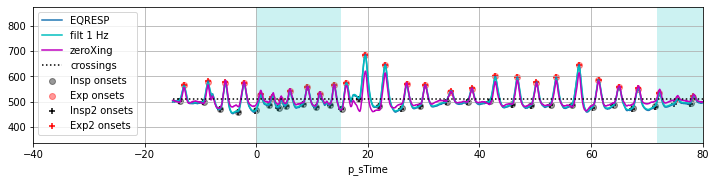

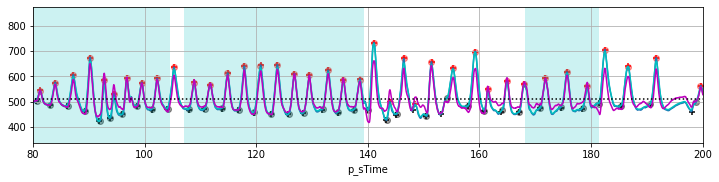

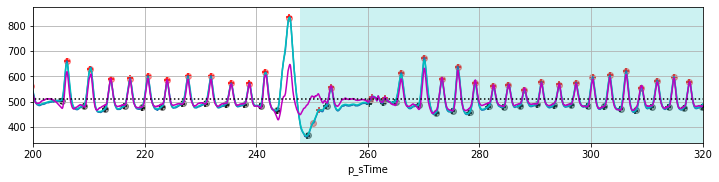

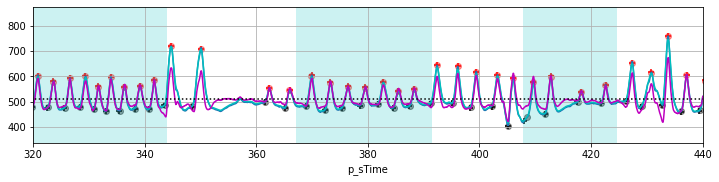

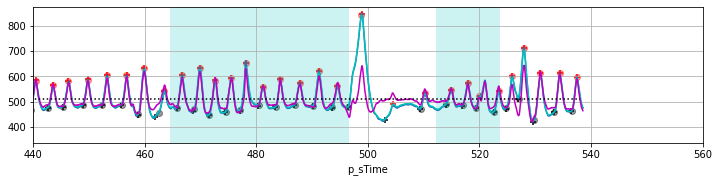

In [479]:
for i in range(5):
    ax = R['Breathing'].plot(figsize = [12,2.5],label = 'EQRESP')
    ax.plot(respnormed(R['Breathing'],filtering_range = [1],scaling=1)+512,'c',label='filt 1 Hz')
    ax.plot(R.loc[:,['Breathing']] - respnormed(R['Breathing'],filtering_range = [0.2],scaling=1),'m',label='zeroXing')
    ax.plot([-15,538],[512,512],c = 'k',linestyle = ':',label='crossings')
#     ax.plot(R.loc[:,['Breathing']] - respnormed(R['Breathing'],filtering_range = [0.3],scaling=1),'y',label='zeroXing2')

    ax.scatter(x=Breaths['In'],y = R.loc[Breaths['In'],'Breathing'],c = 'k',alpha = 0.4,label='Insp onsets')
    ax.scatter(x=Breaths['Ex'],y = R.loc[Breaths['Ex'],'Breathing'],c = 'r',alpha = 0.4,label='Exp onsets')
    ax.scatter(x=Breaths2['In'],y = R.loc[Breaths2['In'],'Breathing'],c = 'k',marker = '+',label='Insp2 onsets')
    ax.scatter(x=Breaths2['Ex'],y = R.loc[Breaths2['Ex'],'Breathing'],c = 'r',marker = '+',label='Exp2 onsets')
    ax.set_xlim([-40+i*120,-40+(i+1)*120])
    ax.grid()
    if i <1: ax.legend()
    eq.play_shade(ax,Pentries,concert,part)
    plt.show()

In these excerpts, we see the default parameters miss some breaths:

- A shallow breath at around 75 s
- A potential shallow breath at around 147 s

There is also an instance of likely false inspirations at 249 s, when the initial increase is more likely to be postural or passive inspiration on the way to a stable lung volumn than an inspiration action. Same at 260 s. Between 250 s and 265 s, expiration onsets are also questionable.

In [480]:
Breaths.query('In>240 and In<260')

In       Ex
75  240.778  241.637
76  243.786  245.896
77  249.294  250.154
78  252.614  253.358

Note on how the EQ respiration wave is already very smooth. 

The respnorm default lowpass filtering, cutoff 1 hz, does nothing to change the signal. This information is already been stripped from the chest stretch signal. A cutoff of 0.5 Hz does change things, though, obscuring some of the missed breaths. The zero crossings criteria.

raising the detrending lowpass cutoff to 0.3 Hz reults in some of the missed breaths getting counted. for exmaple at 505. and maybe better counting at 520 

A better modification is to lower the thresholds for insp velocity. Current is 0.55 of the signals mean insp diff, more inclusive 0.4 captures most of what was missed and more. 

Asside from these cases, the inspiration onsets look to be well placed, at the elbow of increases instead of minima in the middle of post expiration pauses.

The expirations of this performer look mostly elastic, returning smoothly to a fairly consistent baseline rather than extending beyond. 

Inspiration extraction with threshold inpsiration velocity much lower, say with a constant of 0.35 on the average inspiration velocity, gives the most convincing phase change timings for this performer.

# RESPY on first violin 

The concert master has more respirations at higher velocities because some portion of breathing during performance is communicative, not just supporting the actions of their own playing. Faster inspirations are more audible and visible to the players that are meant to follow this violinist's lead. 

In [580]:
partID = 'VN102'
sig_ex = '_'.join([concert,piece,partID])
piece='Arba'
concert = 'C1'
Score_map = pd.read_csv(data_loc+'PlayTimings - Score_parts.csv',index_col = 0)
Pentries = pd.read_csv(data_loc+'PlayTimings_'+piece+'_entries.csv') 
part = Score_map.loc[partID,piece]

R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)
R.set_index('p_sTime',drop=True,inplace=True)
Breaths = rp.Inspiration_Extract(R['Breathing'])  
# rp.Breath_Features(R['Breathing'],scalingfactor=1,filtered=False)
Breaths2 = rp2.Inspiration_Extract(R['Breathing'],False,0.35,0.2)  
[len(Breaths),len(Breaths2)]

[216, 222]

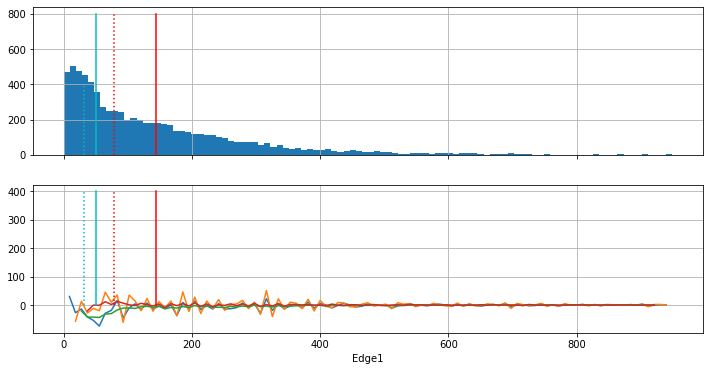

[212.5751271851446, 97.404491431133, 50.22097808118094, 28.697701760674825]


In [581]:
sf = 25.6
newResp = R.loc[:,['Breathing']].copy()
newResp['Filt'] = rp2.respnormed(R['Breathing'],scaling=1)
newResp['Diff1'] = rp2.diffed(newResp['Filt'] )
expansion_dist = newResp['Diff1'].loc[newResp['Diff1']>0].copy()*sf

fig, axes = plt.subplots(2,1,figsize=(12,6),sharex = True)
ax = axes[0]
expansion_dist.hist(bins=100,ax=ax)
ax.plot(np.array([1,1])*expansion_dist.mean(),[0,800],'r')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.55,[0,800],'r',linestyle=':')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.35,[0,800],'c')
# InspThresh = newResp['Diff1'].loc[newResp['Diff1']>0].mean()*sf*vel_c
# VelThresh = InspThresh/sf;
ax = axes[1]
h = np.histogram(expansion_dist,bins=int(4*sf))
dist = pd.DataFrame(columns =['Counts','Edge1','Edge2'])
dist['Edge1'] = h[1][:-1]
dist['Edge2'] = h[1][1:]
dist.set_index('Edge1',inplace = True,drop=False)
dist['Counts'] = h[0]
dist['Counts'].diff().plot(ax=ax)
dist['Counts'].diff().diff().plot(ax=ax)
dist['Counts'].diff().rolling(5,center=True).mean().plot(ax=ax)
dist['Counts'].diff().rolling(5,center=True).mean().diff().plot(ax=ax)
row = dist.loc[dist['Counts'].diff().diff()>0,:].iloc[0]
tent_thresh = (row['Edge1']+row['Edge2'])/2
alt_C = tent_thresh/expansion_dist.mean()
ax.plot(np.array([1,1])*expansion_dist.mean(),[0,400],'r')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.55,[0,400],'r',linestyle=':')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.35,[0,400],'c')
ax.plot(np.array([1,1])*expansion_dist.mean()*alt_C,[0,400],'c',linestyle=':')
axes[0].plot(np.array([1,1])*expansion_dist.mean()*alt_C,[0,400],'c',linestyle=':')
ax.grid()
plt.show()
print([newResp['Diff1'].std()*sf,expansion_dist.median(),expansion_dist.mean()*0.35,expansion_dist.mean()*0.2])

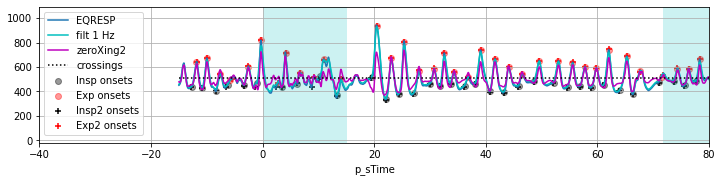

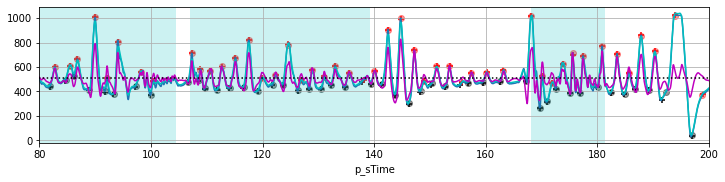

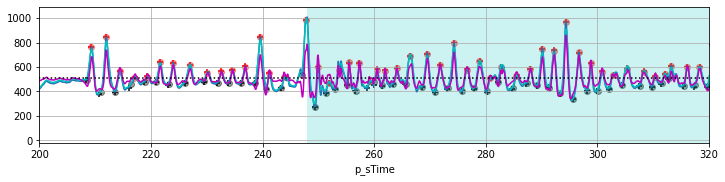

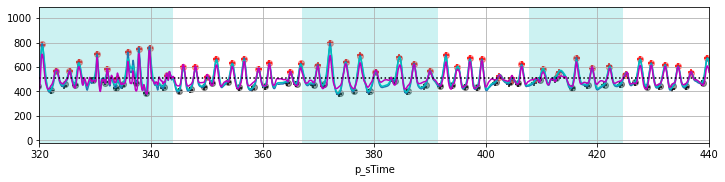

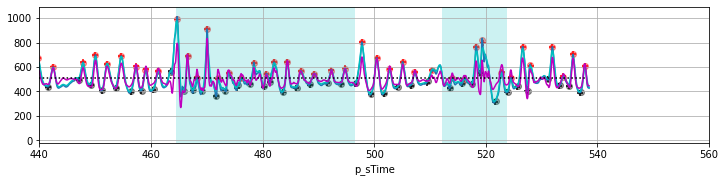

In [466]:
for i in range(5):
    ax = R['Breathing'].plot(figsize = [12,2.5],label = 'EQRESP')
    ax.plot(respnormed(R['Breathing'],filtering_range = [1],scaling=1)+512,'c',label='filt 1 Hz')
    ax.plot(R.loc[:,['Breathing']] - respnormed(R['Breathing'],filtering_range = [0.3],scaling=1),'m',label='zeroXing2')
    ax.plot([-15,538],[512,512],c = 'k',linestyle = ':',label='crossings')

    ax.scatter(x=Breaths['In'],y = R.loc[Breaths['In'],'Breathing'],c = 'k',alpha = 0.4,label='Insp onsets')
    ax.scatter(x=Breaths['Ex'],y = R.loc[Breaths['Ex'],'Breathing'],c = 'r',alpha = 0.4,label='Exp onsets')
    ax.scatter(x=Breaths2['In'],y = R.loc[Breaths2['In'],'Breathing'],c = 'k',marker = '+',label='Insp2 onsets')
    ax.scatter(x=Breaths2['Ex'],y = R.loc[Breaths2['Ex'],'Breathing'],c = 'r',marker = '+',label='Exp2 onsets')
    ax.set_xlim([-40+i*120,-40+(i+1)*120])
    ax.grid()
    if i <1: ax.legend()
    eq.play_shade(ax,Pentries,concert,part)
    plt.show()

A insp vel thresh constant of 0.4 yeilds better results for this player, along with the higher cut off for detrending to zero crossing. However, there are  many moments that may also be spurious inspirations like at 155s or after 400 s. 

At 195 s there is also a clipped inspiration. that needs fixing.

# RESPY on bass

In [483]:
partID = 'LS410'
sig_ex = '_'.join([concert,piece,partID])
piece='Arba'
concert = 'C1'
Score_map = pd.read_csv(data_loc+'PlayTimings - Score_parts.csv',index_col = 0)
Pentries = pd.read_csv(data_loc+'PlayTimings_'+piece+'_entries.csv') 
part = Score_map.loc[partID,piece]

R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)
R.set_index('p_sTime',drop=True,inplace=True)
Breaths = rp.Inspiration_Extract(R['Breathing'])  
# rp.Breath_Features(R['Breathing'],scalingfactor=1,filtered=False)
Breaths2 = rp2.Inspiration_Extract(R['Breathing'],False,0.35,0.2)  
[len(Breaths),len(Breaths2)]

[189, 193]

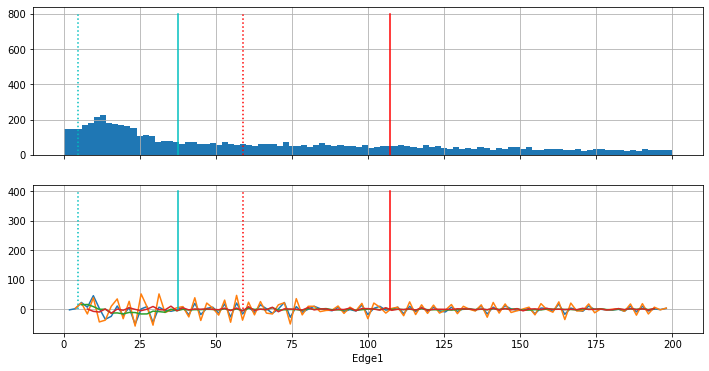

In [484]:
sf = 25.6
newResp = R.loc[:,['Breathing']].copy()
newResp['Filt'] = rp2.respnormed(R['Breathing'],scaling=1)
newResp['Diff1'] = rp2.diffed(newResp['Filt'] )
expansion_dist = newResp['Diff1'].loc[newResp['Diff1']>0].copy()*sf

fig, axes = plt.subplots(2,1,figsize=(12,6),sharex = True)
ax = axes[0]
expansion_dist.hist(bins=100,range=[0,200],ax=ax)
ax.plot(np.array([1,1])*expansion_dist.mean(),[0,800],'r')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.55,[0,800],'r',linestyle=':')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.35,[0,800],'c')
# InspThresh = newResp['Diff1'].loc[newResp['Diff1']>0].mean()*sf*vel_c
# VelThresh = InspThresh/sf;
ax = axes[1]
h = np.histogram(expansion_dist,bins=int(4*sf),range=[0,200])
dist = pd.DataFrame(columns =['Counts','Edge1','Edge2'])
dist['Edge1'] = h[1][:-1]
dist['Edge2'] = h[1][1:]
dist.set_index('Edge1',inplace = True,drop=False)
dist['Counts'] = h[0]
dist['Counts'].diff().plot(ax=ax)
dist['Counts'].diff().diff().plot(ax=ax)
dist['Counts'].diff().rolling(5,center=True).mean().plot(ax=ax)
dist['Counts'].diff().rolling(5,center=True).mean().diff().plot(ax=ax)
row = dist.loc[dist['Counts'].diff().diff()>0,:].iloc[0]
tent_thresh = (row['Edge1']+row['Edge2'])/2
alt_C = tent_thresh/expansion_dist.mean()
ax.plot(np.array([1,1])*expansion_dist.mean(),[0,400],'r')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.55,[0,400],'r',linestyle=':')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.35,[0,400],'c')
ax.plot(np.array([1,1])*expansion_dist.mean()*alt_C,[0,400],'c',linestyle=':')
axes[0].plot(np.array([1,1])*expansion_dist.mean()*alt_C,[0,800],'c',linestyle=':')
ax.grid()
plt.show()

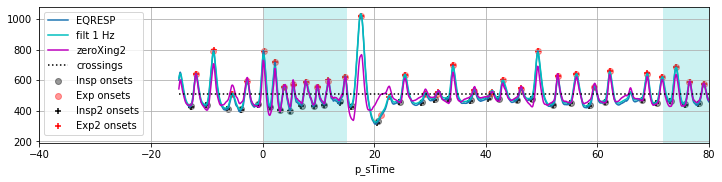

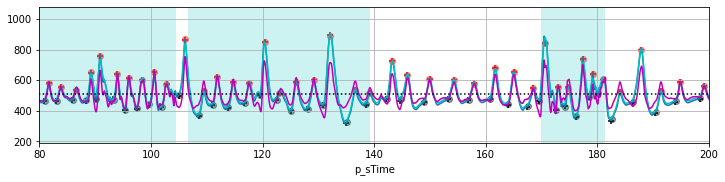

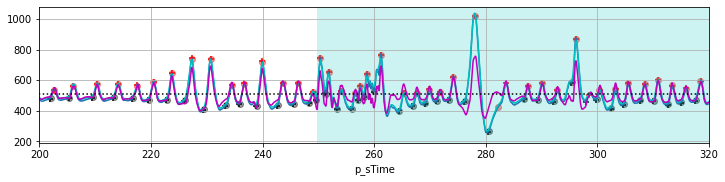

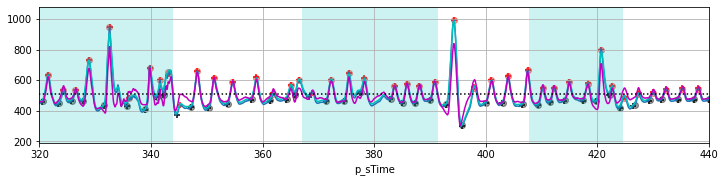

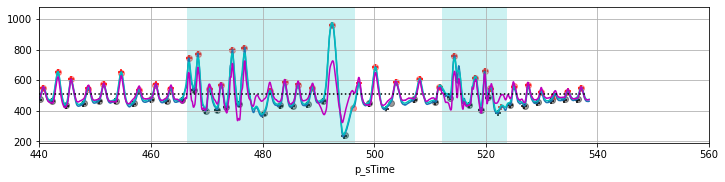

In [485]:
for i in range(5):
    ax = R['Breathing'].plot(figsize = [12,2.5],label = 'EQRESP')
    ax.plot(respnormed(R['Breathing'],filtering_range = [1],scaling=1)+512,'c',label='filt 1 Hz')
    ax.plot(R.loc[:,['Breathing']] - respnormed(R['Breathing'],filtering_range = [0.2],scaling=1),'m',label='zeroXing2')
    ax.plot([-15,538],[512,512],c = 'k',linestyle = ':',label='crossings')

    ax.scatter(x=Breaths['In'],y = R.loc[Breaths['In'],'Breathing'],c = 'k',alpha = 0.4,label='Insp onsets')
    ax.scatter(x=Breaths['Ex'],y = R.loc[Breaths['Ex'],'Breathing'],c = 'r',alpha = 0.4,label='Exp onsets')
    ax.scatter(x=Breaths2['In'],y = R.loc[Breaths2['In'],'Breathing'],c = 'k',marker = '+',label='Insp2 onsets')
    ax.scatter(x=Breaths2['Ex'],y = R.loc[Breaths2['Ex'],'Breathing'],c = 'r',marker = '+',label='Exp2 onsets')
    ax.set_xlim([-40+i*120,-40+(i+1)*120])
    ax.grid()
    if i <1: ax.legend()
    eq.play_shade(ax,Pentries,concert,part)
    plt.show()

This lower threshold (0.35 insp vel) captures the range of inspirations that look like they shoudl be counted but also results in some false breaths following augmented breaths, with or without active expirations, such as around 335s maybe 123s, maybe 345 s.

We could add an exclusion criterion the catch instances of postural or inactive inspiration, either by considerig the sensor values relative to  middle (512) or previous peak, or something about the slope after the following estimated expiration onsets. Maybe an expiration velocity threshold. 

# respy on flute
Respiration on wind instrument players is the greater test of detection criteria. The respiratory behaviour is varied and complex. 

In [486]:
partID = 'WW505'
sig_ex = '_'.join([concert,piece,partID])
piece='Arba'
concert = 'C1'
Score_map = pd.read_csv(data_loc+'PlayTimings - Score_parts.csv',index_col = 0)
Pentries = pd.read_csv(data_loc+'PlayTimings_'+piece+'_entries.csv') 
part = Score_map.loc[partID,piece]

R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)
R.set_index('p_sTime',drop=True,inplace=True)
Breaths = rp.Inspiration_Extract(R['Breathing'])  
# rp.Breath_Features(R['Breathing'],scalingfactor=1,filtered=False)
Breaths2 = rp2.Inspiration_Extract(R['Breathing'],False,0.35,0.2)   
[len(Breaths),len(Breaths2)]

[136, 146]

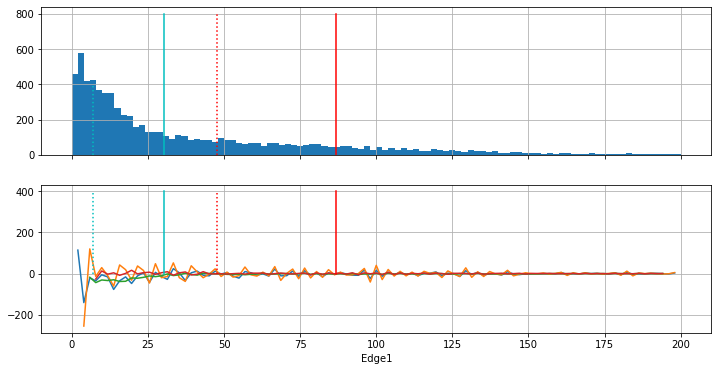

In [487]:
sf = 25.6
newResp = R.loc[:,['Breathing']].copy()
newResp['Filt'] = rp2.respnormed(R['Breathing'],scaling=1)
newResp['Diff1'] = rp2.diffed(newResp['Filt'] )
expansion_dist = newResp['Diff1'].loc[newResp['Diff1']>0].copy()*sf

fig, axes = plt.subplots(2,1,figsize=(12,6),sharex = True)
ax = axes[0]
expansion_dist.hist(bins=100,range=[0,200],ax=ax)
ax.plot(np.array([1,1])*expansion_dist.mean(),[0,800],'r')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.55,[0,800],'r',linestyle=':')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.35,[0,800],'c')
# InspThresh = newResp['Diff1'].loc[newResp['Diff1']>0].mean()*sf*vel_c
# VelThresh = InspThresh/sf;
ax = axes[1]
h = np.histogram(expansion_dist,bins=int(4*sf),range=[0,200])
dist = pd.DataFrame(columns =['Counts','Edge1','Edge2'])
dist['Edge1'] = h[1][:-1]
dist['Edge2'] = h[1][1:]
dist.set_index('Edge1',inplace = True,drop=False)
dist['Counts'] = h[0]
dist['Counts'].diff().plot(ax=ax)
dist['Counts'].diff().diff().plot(ax=ax)
dist['Counts'].diff().rolling(5,center=True).mean().plot(ax=ax)
dist['Counts'].diff().rolling(5,center=True).mean().diff().plot(ax=ax)
row = dist.loc[dist['Counts'].diff().diff()>0,:].iloc[0]
tent_thresh = (row['Edge1']+row['Edge2'])/2
alt_C = tent_thresh/expansion_dist.mean()
ax.plot(np.array([1,1])*expansion_dist.mean(),[0,400],'r')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.55,[0,400],'r',linestyle=':')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.35,[0,400],'c')
ax.plot(np.array([1,1])*expansion_dist.mean()*alt_C,[0,400],'c',linestyle=':')
axes[0].plot(np.array([1,1])*expansion_dist.mean()*alt_C,[0,400],'c',linestyle=':')
ax.grid()
plt.show()

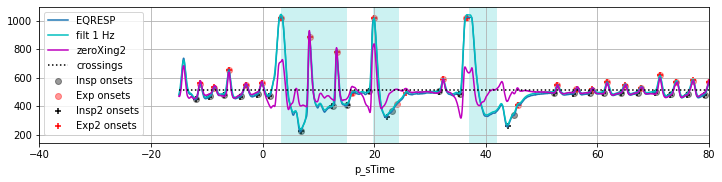

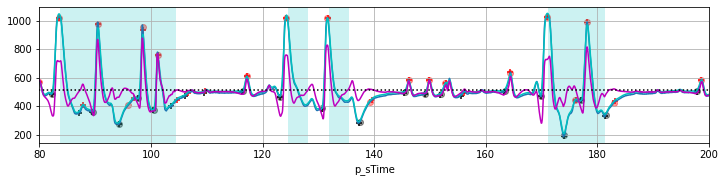

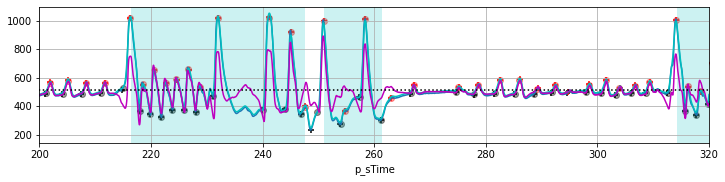

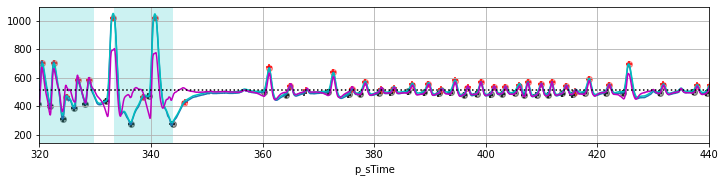

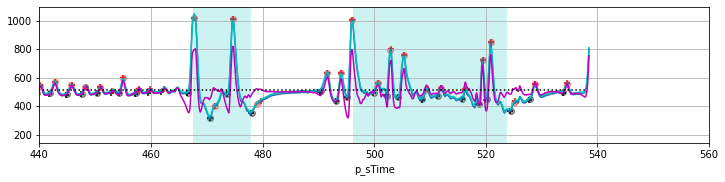

In [488]:
for i in range(5):
    ax = R['Breathing'].plot(figsize = [12,2.5],label = 'EQRESP')
    ax.plot(respnormed(R['Breathing'],filtering_range = [1],scaling=1)+512,'c',label='filt 1 Hz')
    ax.plot(R.loc[:,['Breathing']] - respnormed(R['Breathing'],filtering_range = [0.2],scaling=1),'m',label='zeroXing2')
    ax.plot([-15,538],[512,512],c = 'k',linestyle = ':',label='crossings')

    ax.scatter(x=Breaths['In'],y = R.loc[Breaths['In'],'Breathing'],c = 'k',alpha = 0.4,label='Insp onsets')
    ax.scatter(x=Breaths['Ex'],y = R.loc[Breaths['Ex'],'Breathing'],c = 'r',alpha = 0.4,label='Exp onsets')
    ax.scatter(x=Breaths2['In'],y = R.loc[Breaths2['In'],'Breathing'],c = 'k',marker = '+',label='Insp2 onsets')
    ax.scatter(x=Breaths2['Ex'],y = R.loc[Breaths2['Ex'],'Breathing'],c = 'r',marker = '+',label='Exp2 onsets')
    ax.set_xlim([-40+i*120,-40+(i+1)*120])
    ax.grid()
    if i <1: ax.legend()
    eq.play_shade(ax,Pentries,concert,part)
    plt.show()

Flute playing involves low pressure and high volume expiration flow. As such the inspirations preceeding lines of playing are extremely big relative to the breaths during tacet intervals, especially with EQs adaptive range. This means the thresholds of the default respy inspiration detection end often miss breaths during tacit intervals because the segment. However the lowering the inspiration velocity threshold of counting breaths also results in a lot of false breaths because this respiratory work ASLO often involves active expirations below the stable threshold AND longer intervals without inspirations after playing to avoid hyperventilation. 

Another feature of this kind of playing is around 220s and 320s, where the player seems to take very small frequent inspiratios to support short (bar length) expirations. On a wind instrument with air flow resistence, these sequences of short utterances wouldn't require intermediate inspirations, however the flute's transverse air flow does not allow players to start utterances so easily on retained air.

Another problem with the EQ range adaptation is that it clips big inspirations when they exceed the immediately expected range. The entry before 40 s shows this flat top thresholding that confuses the detection algorithm. According to the entry notated in the performance, the point of expiration onset shoudl be around the middle fo that flat section. For flute, at least, setting expiration onset on the midpoint of these kinds of sensor errors would be a safer approximation of the missing info. Lets see if the same goes for the brass players.

For suitable breath counting on flute, we need some exclusion criteria for chest stretch changes that are robust to the range shifts produced by this exceptional wide inspiratory range for this instrument so other breaths aren't missed, expirations as well placed when the wave is cliped, and criteria for allowing gentle non-active-inspirations as the players respiratory system returns to baseline. 

# respy on brass, high flow

In [489]:
partID = 'BR601'
sig_ex = '_'.join([concert,piece,partID])
piece='Arba'
concert = 'C1'
Score_map = pd.read_csv(data_loc+'PlayTimings - Score_parts.csv',index_col = 0)
Pentries = pd.read_csv(data_loc+'PlayTimings_'+piece+'_entries.csv') 
part = Score_map.loc[partID,piece]

R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)
R.set_index('p_sTime',drop=True,inplace=True)
Breaths = rp.Inspiration_Extract(R['Breathing'])  
# rp.Breath_Features(R['Breathing'],scalingfactor=1,filtered=False)
Breaths2 = rp2.Inspiration_Extract(R['Breathing'],False,0.35,0.2)    
[len(Breaths),len(Breaths2)]

[121, 158]

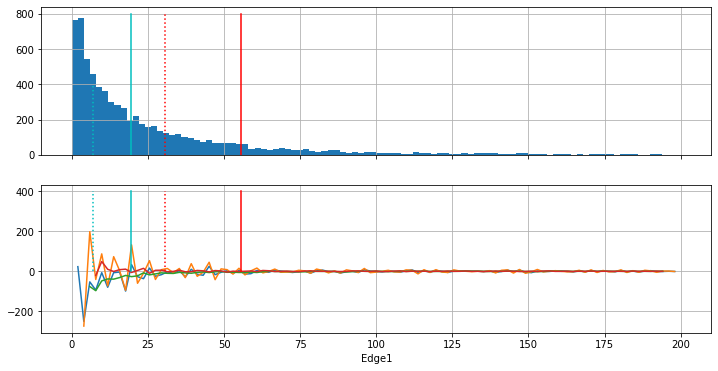

In [491]:
sf = 25.6
newResp = R.loc[:,['Breathing']].copy()
newResp['Filt'] = rp2.respnormed(R['Breathing'],scaling=1)
newResp['Diff1'] = rp2.diffed(newResp['Filt'] )
expansion_dist = newResp['Diff1'].loc[newResp['Diff1']>0].copy()*sf

fig, axes = plt.subplots(2,1,figsize=(12,6),sharex = True)
ax = axes[0]
expansion_dist.hist(bins=100,range=[0,200],ax=ax)
ax.plot(np.array([1,1])*expansion_dist.mean(),[0,800],'r')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.55,[0,800],'r',linestyle=':')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.35,[0,800],'c')
# InspThresh = newResp['Diff1'].loc[newResp['Diff1']>0].mean()*sf*vel_c
# VelThresh = InspThresh/sf;
ax = axes[1]
h = np.histogram(expansion_dist,bins=int(4*sf),range=[0,200])
dist = pd.DataFrame(columns =['Counts','Edge1','Edge2'])
dist['Edge1'] = h[1][:-1]
dist['Edge2'] = h[1][1:]
dist.set_index('Edge1',inplace = True,drop=False)
dist['Counts'] = h[0]
dist['Counts'].diff().plot(ax=ax)
dist['Counts'].diff().diff().plot(ax=ax)
dist['Counts'].diff().rolling(5,center=True).mean().plot(ax=ax)
dist['Counts'].diff().rolling(5,center=True).mean().diff().plot(ax=ax)
row = dist.loc[dist['Counts'].diff().diff()>0,:].iloc[0]
tent_thresh = (row['Edge1']+row['Edge2'])/2
alt_C = tent_thresh/expansion_dist.mean()
ax.plot(np.array([1,1])*expansion_dist.mean(),[0,400],'r')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.55,[0,400],'r',linestyle=':')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.35,[0,400],'c')
ax.plot(np.array([1,1])*expansion_dist.mean()*alt_C,[0,400],'c',linestyle=':')
axes[0].plot(np.array([1,1])*expansion_dist.mean()*alt_C,[0,400],'c',linestyle=':')
ax.grid()
plt.show()

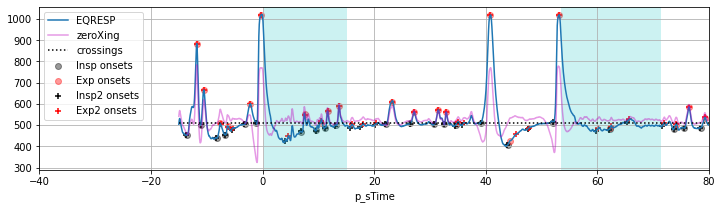

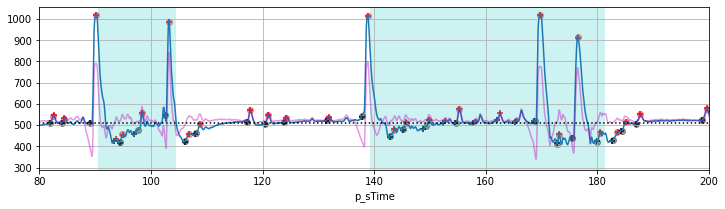

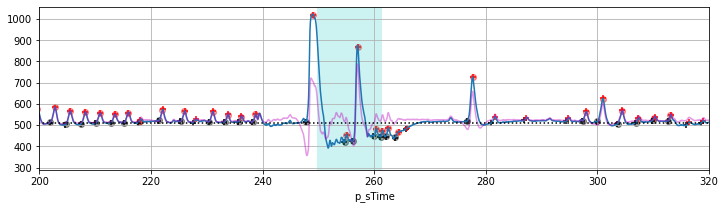

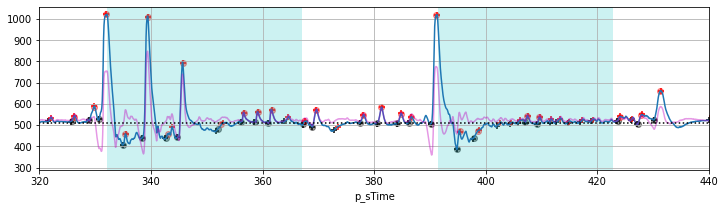

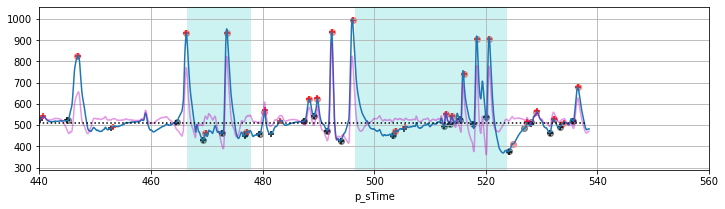

In [492]:
for i in range(5):
    ax = R['Breathing'].plot(figsize = [12,3],label = 'EQRESP')
    ax.plot(R.loc[:,['Breathing']] - respnormed(R['Breathing'],filtering_range = [0.2],scaling=1),'m',alpha = 0.4,label='zeroXing')
    ax.plot([-15,538],[512,512],c = 'k',linestyle = ':',label='crossings')

    ax.scatter(x=Breaths['In'],y = R.loc[Breaths['In'],'Breathing'],c = 'k',alpha = 0.4,label='Insp onsets')
    ax.scatter(x=Breaths['Ex'],y = R.loc[Breaths['Ex'],'Breathing'],c = 'r',alpha = 0.4,label='Exp onsets')
    ax.scatter(x=Breaths2['In'],y = R.loc[Breaths2['In'],'Breathing'],c = 'k',marker = '+',label='Insp2 onsets')
    ax.scatter(x=Breaths2['Ex'],y = R.loc[Breaths2['Ex'],'Breathing'],c = 'r',marker = '+',label='Exp2 onsets')
    ax.set_xlim([-40+i*120,-40+(i+1)*120])
    ax.grid()
    if i <1: ax.legend()
    eq.play_shade(ax,Pentries,concert,part)
    plt.show()

Because of the extreme range of respiratory volumns during Tuba playing, the lower threshold of 0.35 does a better job at capturing the breaths while this player is tacet, say at 280s, however there are many instances that look like misidentified inpsirations and expirations, including moments when the expiration onsets are not followed by a decrease in chest circupherence amd when the inspiraiton intervals look to be short and in the low volumn end of the respiratory range, say after 450s, or 500 s. For players that need a high respiratory pressure for articulated onsets (brass), some of these small increases at moments like 260s may be more a matter of diaphram and respiratory muscles shifting to increase pressure rather than a specifi increase in lung volumn through active inspiration. 

# RESPY on Brass, high pressure

In [582]:
partID = 'BR603'
sig_ex = '_'.join([concert,piece,partID])
piece='Arba'
concert = 'C1'
Score_map = pd.read_csv(data_loc+'PlayTimings - Score_parts.csv',index_col = 0)
Pentries = pd.read_csv(data_loc+'PlayTimings_'+piece+'_entries.csv') 
part = Score_map.loc[partID,piece]

R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)
R.set_index('p_sTime',drop=True,inplace=True)
Breaths = rp.Inspiration_Extract(R['Breathing'])  
# rp.Breath_Features(R['Breathing'],scalingfactor=1,filtered=False)
Breaths2 = rp2.Inspiration_Extract(R['Breathing'],False,0.35,0.2) 
[len(Breaths),len(Breaths2)]

[155, 163]

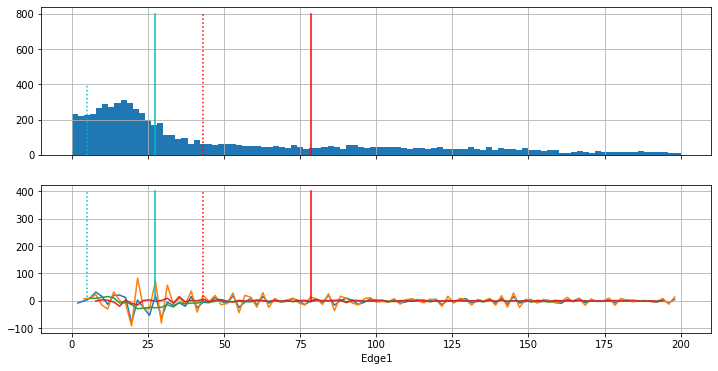

[131.98926467816227, 33.40392134663186, 27.441978282320747, 15.68113044704043]


In [583]:
sf = 25.6
newResp = R.loc[:,['Breathing']].copy()
newResp['Filt'] = rp2.respnormed(R['Breathing'],scaling=1)
newResp['Diff1'] = rp2.diffed(newResp['Filt'] )
expansion_dist = newResp['Diff1'].loc[newResp['Diff1']>0].copy()*sf

fig, axes = plt.subplots(2,1,figsize=(12,6),sharex = True)
ax = axes[0]
expansion_dist.hist(bins=100,range=[0,200],ax=ax)
ax.plot(np.array([1,1])*expansion_dist.mean(),[0,800],'r')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.55,[0,800],'r',linestyle=':')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.35,[0,800],'c')
# InspThresh = newResp['Diff1'].loc[newResp['Diff1']>0].mean()*sf*vel_c
# VelThresh = InspThresh/sf;
ax = axes[1]
h = np.histogram(expansion_dist,bins=int(4*sf),range=[0,200])
dist = pd.DataFrame(columns =['Counts','Edge1','Edge2'])
dist['Edge1'] = h[1][:-1]
dist['Edge2'] = h[1][1:]
dist.set_index('Edge1',inplace = True,drop=False)
dist['Counts'] = h[0]
dist['Counts'].diff().plot(ax=ax)
dist['Counts'].diff().diff().plot(ax=ax)
dist['Counts'].diff().rolling(5,center=True).mean().plot(ax=ax)
dist['Counts'].diff().rolling(5,center=True).mean().diff().plot(ax=ax)
row = dist.loc[dist['Counts'].diff().diff()>0,:].iloc[0]
tent_thresh = (row['Edge1']+row['Edge2'])/2
alt_C = tent_thresh/expansion_dist.mean()
ax.plot(np.array([1,1])*expansion_dist.mean(),[0,400],'r')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.55,[0,400],'r',linestyle=':')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.35,[0,400],'c')
ax.plot(np.array([1,1])*expansion_dist.mean()*alt_C,[0,400],'c',linestyle=':')
axes[0].plot(np.array([1,1])*expansion_dist.mean()*alt_C,[0,400],'c',linestyle=':')
ax.grid()
plt.show()
print([newResp['Diff1'].std()*sf,expansion_dist.median(),expansion_dist.mean()*0.35,expansion_dist.mean()*0.2])

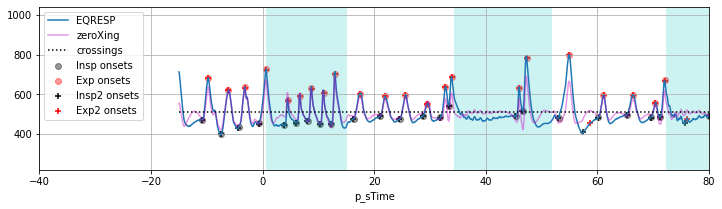

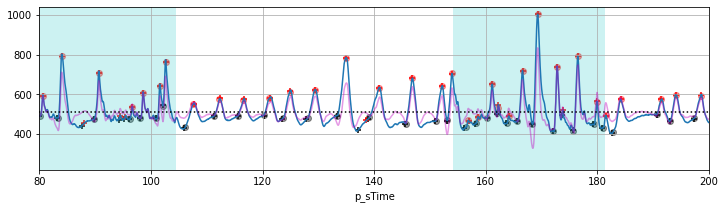

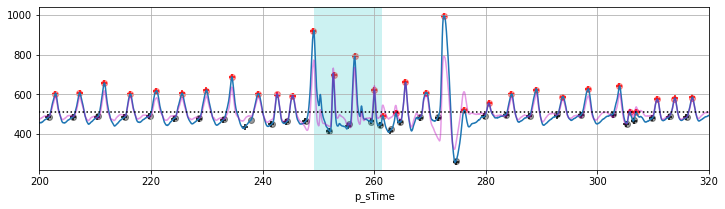

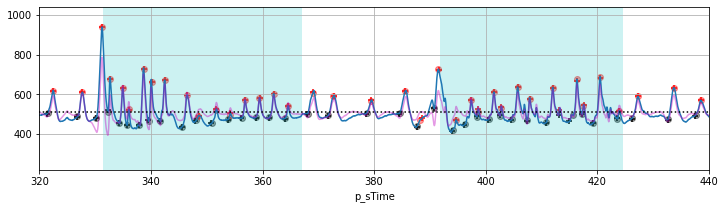

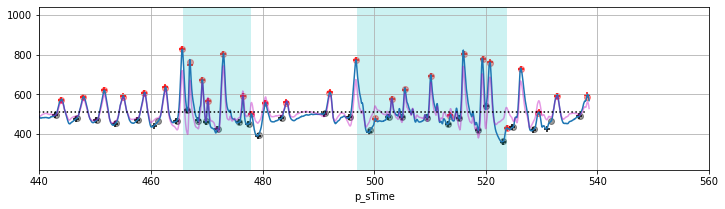

In [495]:
for i in range(5):
    ax = R['Breathing'].plot(figsize = [12,3],label = 'EQRESP')
    ax.plot(R.loc[:,['Breathing']] - respnormed(R['Breathing'],filtering_range = [0.2],scaling=1),'m',alpha = 0.4,label='zeroXing')
    ax.plot([-15,538],[512,512],c = 'k',linestyle = ':',label='crossings')

    ax.scatter(x=Breaths['In'],y = R.loc[Breaths['In'],'Breathing'],c = 'k',alpha = 0.4,label='Insp onsets')
    ax.scatter(x=Breaths['Ex'],y = R.loc[Breaths['Ex'],'Breathing'],c = 'r',alpha = 0.4,label='Exp onsets')
    ax.scatter(x=Breaths2['In'],y = R.loc[Breaths2['In'],'Breathing'],c = 'k',marker = '+',label='Insp2 onsets')
    ax.scatter(x=Breaths2['Ex'],y = R.loc[Breaths2['Ex'],'Breathing'],c = 'r',marker = '+',label='Exp2 onsets')
    ax.set_xlim([-40+i*120,-40+(i+1)*120])
    ax.grid()
    if i <1: ax.legend()
    eq.play_shade(ax,Pentries,concert,part)
    plt.show()

The high pressure brass playing shows less extreme inpsiration for playing, consistent with a lower volumn flow of air neede for playing, however the characteristics of expirations show a lot of intermediate peaks. These moments could be small quick inspirations or simply a matter of resettling the abdominal and diaphrams muscles for a stronger articulated onset. The passages around 170s [82m] and 250s [122m] make it looks like these were quich adjustments for accented notes in a line without rests, not real inspirations. 

The respy and respy with lower threshold are also catching chest expansion intervals that are to baseline rather than active inspirations.

A clue as to how to exclude the increases for articilation on unbroken lines would be "inspiration" duration in time, even if relative velocity is not a stable concept on these adaptive units.  
The non-inspiration chest expansions could also be cut by virtue of the lack of depth in the paired expiration. 

# Modifying inspiration detection

The current zero crossing algorythm is too conservative for all of these cases and it misinterprete extended respiratory actions and states needed in active performance contexts. Here we test additional heuristics so that more inclusive thresholds are not overwhelmed by bad cases.

The inspiration detection function is intended to capture ACTIVE INSPIRATIONS. Active inspirations are followed by expirations (active or elastic) and sometimes post expiration pauses. 

In the examples of performer respiration reviewed so far, I haven't seen examples of Post Inspiration Pauses, maybe because these performers tasks are temporally predictable in a way that makes that kind of suspended preparation inefficient and avoidable. So adding post expiration pause detection conditions can wait for another data set. There may be some in the Lydo 2024 set, at moments when the musicians and MC were supposed to be alternating speaking and playing to introduce WTO themes and there were major timing flubs nearly every time. 

## cuting false inspirations from articulatory resets 

In [792]:
def breath_feats(Breaths2):
    Breaths2['IDepth'] = R.loc[Breaths2['Ex'],'Breathing'].values-R.loc[Breaths2['In'],'Breathing'].values
    Breaths2.loc[:len(Breaths2)-2,'EDepth'] = R.loc[Breaths2.loc[:len(Breaths2)-2,'Ex'],'Breathing'].values-R.loc[Breaths2.loc[1:,'In'],'Breathing'].values

    Breaths2['Insp_T'] = Breaths2['Ex'] - Breaths2['In']
    a = Breaths2['In'].diff()
    Breaths2.loc[:len(Breaths2)-2,'Period_T'] = a[1:].values
    Breaths2['Exp_T'] = Breaths2['Period_T'] - Breaths2['Insp_T']
    Breaths2['IE_Ratio'] = Breaths2['Insp_T']/Breaths2['Exp_T'] 
    Breaths2.loc[:len(Breaths2)-2,'IE_DR'] = Breaths2.loc[:len(Breaths2)-2,'IDepth']/Breaths2.loc[:len(Breaths2)-2,'EDepth'] 
    Breaths2['Insp_V'] = Breaths2['IDepth']/Breaths2['Insp_T']
    Breaths2['Exp_V'] = Breaths2['EDepth']/Breaths2['Exp_T']
#     Breaths2['RelID'] = 2*Breaths2['IDepth']/(Breaths2['IDepth'].shift(1)+Breaths2['IDepth'].shift(-1))
#     Breaths2['RelED'] = 2*Breaths2['EDepth']/(Breaths2['EDepth'].shift(1)+Breaths2['EDepth'].shift(-1))
    Breaths2['RelID'] = Breaths2['IDepth']/Breaths2['IDepth'].rolling(5,center=True).median()
    Breaths2['RelED'] = Breaths2['EDepth']/Breaths2['EDepth'].rolling(5,center=True).median()

    Breaths2.replace([np.inf, -np.inf], np.nan, inplace=True)
    return Breaths2
#Breaths2

In [806]:
partID = 'BR601'
sig_ex = '_'.join([concert,piece,partID])
piece='Arba'
concert = 'C1'
Score_map = pd.read_csv(data_loc+'PlayTimings - Score_parts.csv',index_col = 0)
Pentries = pd.read_csv(data_loc+'PlayTimings_'+piece+'_entries.csv') 
part = Score_map.loc[partID,piece]

R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)
R.set_index('p_sTime',drop=True,inplace=True)
Breaths = rp.Inspiration_Extract(R['Breathing'])  
# rp.Breath_Features(R['Breathing'],scalingfactor=1,filtered=False)
Breaths2 = breath_feats(rp2.Inspiration_Extract(R['Breathing'],False,0.2,0.2))
[len(Breaths),len(Breaths2)]

[121, 176]

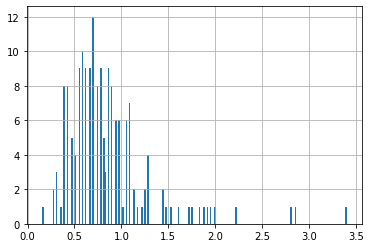

In [807]:
Breaths2['Insp_T'].hist(bins = 200)
plt.show()
# Breaths2.query('Insp_T<0.5').sort_values(by=['Insp_T'])

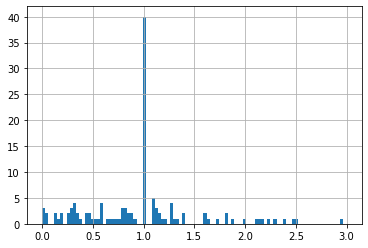

In [808]:
Breaths2['RelED'].hist(bins = 100,range=[0,3])
plt.show()
# Breaths2.query('Insp_T<0.5').sort_values(by=['Insp_T'])

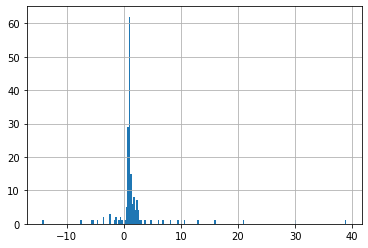

In       Ex  IDepth  EDepth  Insp_T  Period_T  Exp_T  IE_Ratio  \
63   182.556  183.845      43    -3.0   1.289     1.485  0.196  6.576531   
113  351.593  353.038      38    -5.0   1.445     4.415  2.970  0.486532   
152  469.337  469.884      28    -5.0   0.547     3.359  2.812  0.194523   
88   263.617  264.554      32    -6.0   0.937     1.719  0.782  1.198210   
150  460.703  462.695      33    -7.0   1.992     3.711  1.719  1.158813   
120  372.649  374.173      28    -8.0   1.524     4.688  3.164  0.481669   
174  533.170  534.030      28    -8.0   0.860     2.383  1.523  0.564675   
27    61.960   62.546      20    -8.0   0.586     2.266  1.680  0.348810   
161  503.246  503.949      24   -10.0   0.703     1.992  1.289  0.545384   
147  452.616  453.320      12    -5.0   0.704     2.072  1.368  0.514620   
89   265.336  267.094      27   -16.0   1.758     7.774  6.016  0.292221   
148  454.688  455.508      12    -8.0   0.820     3.398  2.578  0.318076   
81   243.342  243.733       8    -6.0   0.391     4.415  4.024  0.097167   
143  435.232  436.131      13   -16.0   0.899     4.727  3.828  0.234848   
4     -5.545   -5.154      10   -18.0   0.391     2.266  1.875  0.208533   
24    47.311   48.014      12   -23.0   0.703     4.765  4.062  0.173067   
44   109.542  109.816       9   -23.0   0.274     7.618  7.344  0.037309   

         IE_DR     Insp_V      Exp_V     RelID     RelED  
63  -14.333333  33.359193 -15.306122  0.955556 -0.107143  
113  -7.600000  26.297578  -1.683502  0.883721 -0.113636  
152  -5.600000  51.188300  -1.778094  0.848485 -0.454545  
88   -5.333333  34.151547  -7.672634  1.103448 -0.375000  
150  -4.714286  16.566265  -4.072135  1.178571  1.400000  
120  -3.500000  18.372703  -2.528445  0.682927 -0.186047  
174  -3.500000  32.558140  -5.252791       NaN       NaN  
27   -2.500000  34.129693  -4.761905  1.052632 -0.727273  
161  -2.400000  34.139403  -7.757952  1.000000 -1.428571  
147  -2.400000  17.045455  -3.654971  1.000000 -0.714286  
89   -1.687500  15.358362  -2.659574  0.843750 -1.000000  
148  -1.500000  14.634146  -3.103181  1.000000  1.600000  
81   -1.333333  20.460358  -1.491054  0.228571 -0.193548  
143  -0.812500  14.460512  -4.179728  0.282609 -0.640000  
4    -0.555556  25.575448  -9.600000  0.156250 -0.352941  
24   -0.521739  17.069701  -5.662235  0.153846 -2.090909  
44   -0.391304  32.846715  -3.131808  0.209302 -1.045455

In [809]:
Breaths2['IE_DR'].hist(bins = 200)
plt.show()
Breaths2.query('IE_DR<0').sort_values(by=['IE_DR'])

In [810]:
Breaths3=Breaths2.copy()

In [811]:
thresh = 0.4 # s
Breaths3 = breath_feats(Breaths3.loc[Breaths3['Insp_T']>thresh,['In','Ex']].reset_index(drop = True))

In [812]:
thresh = 0
Breaths3 = breath_feats(Breaths3.loc[Breaths3['IE_DR']>thresh,['In','Ex']].reset_index(drop = True))

In [813]:
# thresh = 0.25
# Breaths3 = breath_feats(Breaths3.loc[Breaths3['RelID']>thresh,['In','Ex']].reset_index(drop = True))

In [814]:
# # cutting short expirations by ration to inspiration
# thresh = 0.25
# B=pd.DataFrame()
# J = Breaths3['RelED']>thresh
# J.iloc[-1] = True
# K = Breaths3['RelED'].shift(1)>thresh
# K.loc[0] = True
# B.loc[:,'In']= Breaths3.loc[K,'In'].values
# B.loc[:,'Ex']= Breaths3.loc[J,'Ex'].values
# Breaths3 = breath_feats(B)

In [815]:
[len(Breaths),len(Breaths2),len(Breaths3)]

[121, 176, 144]

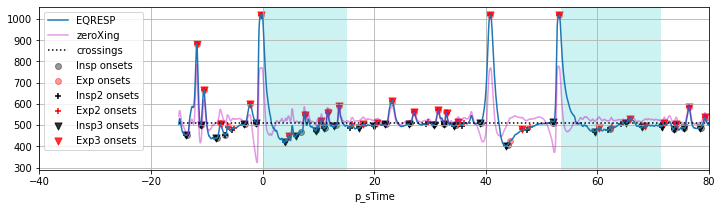

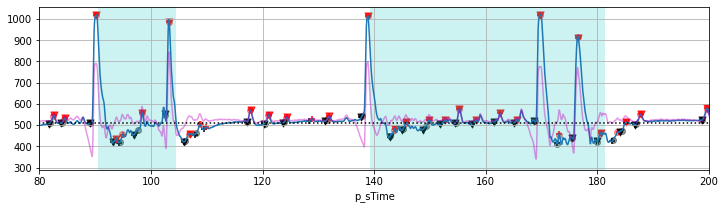

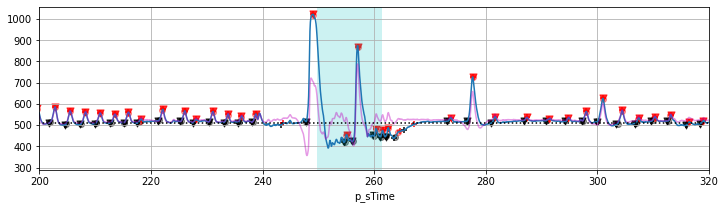

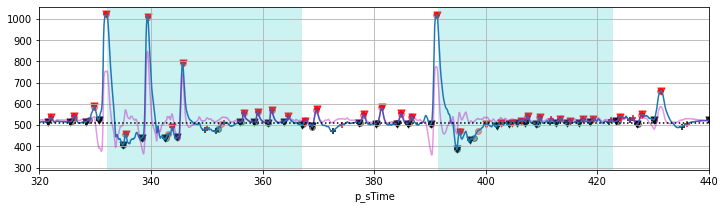

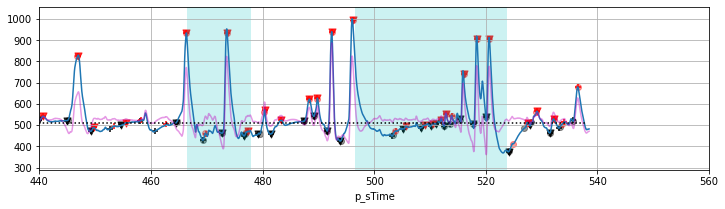

In [816]:
for i in range(5):
    ax = R['Breathing'].plot(figsize = [12,3],label = 'EQRESP')
    ax.plot(R.loc[:,['Breathing']] - respnormed(R['Breathing'],filtering_range = [0.2],scaling=1),'m',alpha = 0.4,label='zeroXing')
    ax.plot([-15,538],[512,512],c = 'k',linestyle = ':',label='crossings')
    
    ax.scatter(x=Breaths['In'],y = R.loc[Breaths['In'],'Breathing'],c = 'k',alpha = 0.4,label='Insp onsets')
    ax.scatter(x=Breaths['Ex'],y = R.loc[Breaths['Ex'],'Breathing'],c = 'r',alpha = 0.4,label='Exp onsets')
    ax.scatter(x=Breaths2['In'],y = R.loc[Breaths2['In'],'Breathing'],c = 'k',marker = '+',label='Insp2 onsets')
    ax.scatter(x=Breaths2['Ex'],y = R.loc[Breaths2['Ex'],'Breathing'],c = 'r',marker = '+',label='Exp2 onsets')
    ax.scatter(x=Breaths3['In'],y = R.loc[Breaths3['In'],'Breathing'],c = 'k',marker = 'v',s = 50,alpha = 0.8,label='Insp3 onsets')
    ax.scatter(x=Breaths3['Ex'],y = R.loc[Breaths3['Ex'],'Breathing'],c = 'r',marker = 'v',s = 50,alpha = 0.8,label='Exp3 onsets')
    ax.set_xlim([-40+i*120,-40+(i+1)*120])
    ax.grid()
    if i <1: ax.legend()
    eq.play_shade(ax,Pentries,concert,part)
    plt.show()

The two thresholds, on inspiration duration (> 250 ms) and on expiration depth (> 0) seem to help with many of the problem inspirations in this dataset. 

What about a high flow low pressure wind like the Tuba?

In [973]:
partID = 'BR601'
sig_ex = '_'.join([concert,piece,partID])
piece='Arba'
concert = 'C1'
Score_map = pd.read_csv(data_loc+'PlayTimings - Score_parts.csv',index_col = 0)
Pentries = pd.read_csv(data_loc+'PlayTimings_'+piece+'_entries.csv') 
part = Score_map.loc[partID,piece]

R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)
R.set_index('p_sTime',drop=True,inplace=True)
Breaths = rp.Inspiration_Extract(R['Breathing'])  
# rp.Breath_Features(R['Breathing'],scalingfactor=1,filtered=False)
Breaths2 = breath_feats(rp2.Inspiration_Extract(R['Breathing'],filtered=True,vel_c = 0.35,x_hz=0.2))
Breaths3 = breath_feats(rp2.EQ_Inspiration_Extract(R['Breathing']))

[len(Breaths),len(Breaths2),len(Breaths3)]

Clipped!


[121, 203, 131]

In [972]:
Breaths3=Breaths2.copy()

In [718]:
# cutting short inspirations
thresh = 0.25#0.25 # s
Breaths3 = breath_feats(Breaths3.loc[Breaths3['Insp_T']>thresh,['In','Ex']].reset_index(drop = True))

In [719]:
# cutting short expirations by ration to inspiration
thresh = 2
B=pd.DataFrame()
J = Breaths3['IE_Ratio']<thresh
J.iloc[-1] = True
K = Breaths3['IE_Ratio'].shift(1)<thresh
K.loc[0] = True
B.loc[:,'In']= Breaths3.loc[K,'In'].values
B.loc[:,'Ex']= Breaths3.loc[J,'Ex'].values
Breaths3 = breath_feats(B)

In [721]:
# cutting expirations that end with higher values than they started, so not actual expiring
thresh = 0
Breaths3 = breath_feats(Breaths3.loc[Breaths3['IE_DR']>thresh,['In','Ex']].reset_index(drop = True))

In [721]:
# cutting expirations that end with higher values than they started, so not actual expiring
thresh = 512-
Breaths3 = breath_feats(Breaths3.loc[Breaths3['IE_DR']>thresh,['In','Ex']].reset_index(drop = True))

In [722]:
[len(Breaths),len(Breaths2),len(Breaths3)]

[121, 203, 111]

<Axes: >

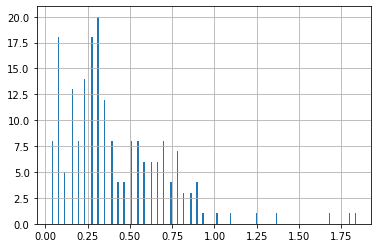

In [723]:
Breaths2['Insp_T'].hist(bins = 200)

<Axes: >

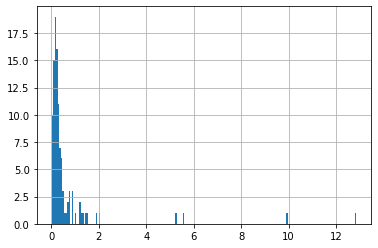

In [724]:
Breaths3['IE_Ratio'].hist(bins = 200)
# plt.show()
# Breaths3.query('IE_DR<0')#.sort_values(by=['IE_DR'])

In [726]:
Breaths3

In       Ex  IDepth  EDepth  Insp_T  Period_T  Exp_T  IE_Ratio  \
0    -13.397   -2.185     144    96.0  11.212    12.344  1.132  9.904594   
1     -1.053   -0.271     514   594.0   0.782     5.430  4.648  0.168244   
2      4.377    4.651      25    22.0   0.274     0.664  0.390  0.702564   
3      5.041    5.354      68    29.0   0.313     2.111  1.798  0.174082   
4      7.152    7.503      89    64.0   0.351     4.218  3.867  0.090768   
..       ...      ...     ...     ...     ...       ...    ...       ...   
106  517.857  518.404     433   293.0   0.547     1.250  0.703  0.778094   
107  519.107  519.419      83   187.0   0.312     1.015  0.703  0.443812   
108  520.122  520.630     392   537.0   0.508     4.024  3.516  0.144482   
109  524.146  528.639     167    77.0   4.493     7.423  2.930  1.533447   
110  531.569  532.115      64     NaN   0.546       NaN    NaN       NaN   

        IE_DR      Insp_V       Exp_V     RelID     RelED  
0    1.500000   12.843382   84.805654       NaN       NaN  
1    0.865320  657.289003  127.796902       NaN       NaN  
2    1.136364   91.240876   56.410256       NaN       NaN  
3    2.344828  217.252396   16.129032       NaN       NaN  
4    1.390625  253.561254   16.550297  1.000000  1.000000  
..        ...         ...         ...       ...       ...  
106  1.477816  791.590494  416.785206  4.163462  6.104167  
107  0.443850  266.025641  266.002845  1.000000  1.000000  
108  0.729981  771.653543  152.730375  1.626556  1.974265  
109  2.168831   37.168929   26.279863  0.692946  0.283088  
110       NaN  117.216117         NaN  0.383234       NaN  

[111 rows x 13 columns]

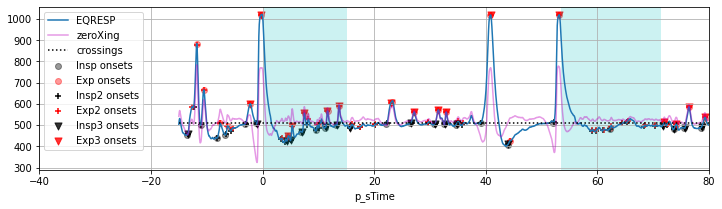

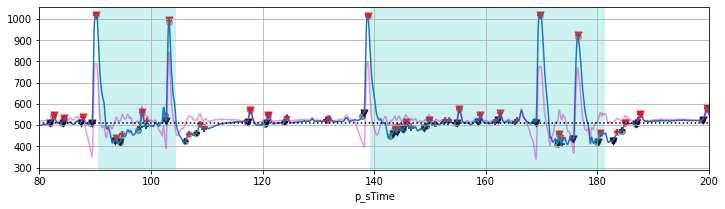

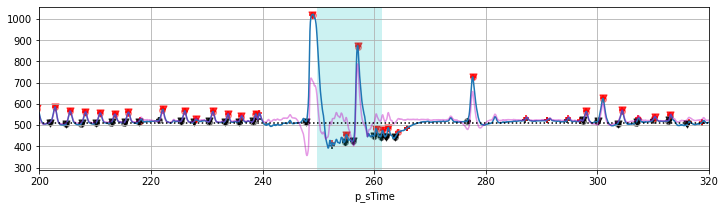

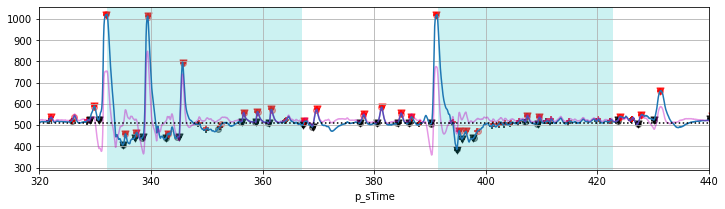

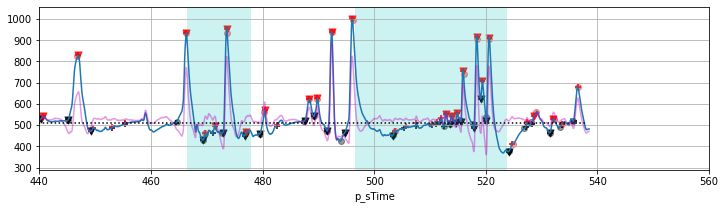

In [725]:
for i in range(5):
    ax = R['Breathing'].plot(figsize = [12,3],label = 'EQRESP')
    ax.plot(R.loc[:,['Breathing']] - respnormed(R['Breathing'],filtering_range = [0.2],scaling=1),'m',alpha = 0.4,label='zeroXing')
    ax.plot([-15,538],[512,512],c = 'k',linestyle = ':',label='crossings')
    
    ax.scatter(x=Breaths['In'],y = R.loc[Breaths['In'],'Breathing'],c = 'k',alpha = 0.4,label='Insp onsets')
    ax.scatter(x=Breaths['Ex'],y = R.loc[Breaths['Ex'],'Breathing'],c = 'r',alpha = 0.4,label='Exp onsets')
    ax.scatter(x=Breaths2['In'],y = R.loc[Breaths2['In'],'Breathing'],c = 'k',marker = '+',label='Insp2 onsets')
    ax.scatter(x=Breaths2['Ex'],y = R.loc[Breaths2['Ex'],'Breathing'],c = 'r',marker = '+',label='Exp2 onsets')
    ax.scatter(x=Breaths3['In'],y = R.loc[Breaths3['In'],'Breathing'],c = 'k',marker = 'v',s = 50,alpha = 0.8,label='Insp3 onsets')
    ax.scatter(x=Breaths3['Ex'],y = R.loc[Breaths3['Ex'],'Breathing'],c = 'r',marker = 'v',s = 50,alpha = 0.8,label='Exp3 onsets')
    ax.set_xlim([-40+i*120,-40+(i+1)*120])
    ax.grid()
    if i <1: ax.legend()
    eq.play_shade(ax,Pentries,concert,part)
    plt.show()

The new filtering criteria do better at avoiding spurious inspirations thant earlier versions. 445s, 500s are clear from inspriations that are not really inspirations. The span of plauing from 330s to 420 is more complicated to parse. This interval has the tuba playing a lot of repeating short patterns with rests most of the bar, making it likely that some breaths occure. 

# Capturing flute better

In [514]:
def breath_cycles(Breaths2,R):
    Breaths2['In_C'] = R.loc[Breaths2['In'],'Breathing'].values
    Breaths2['Ex_C'] = R.loc[Breaths2['Ex'],'Breathing'].values
    Breaths2['IDepth'] = R.loc[Breaths2['Ex'],'Breathing'].values-R.loc[Breaths2['In'],'Breathing'].values
    Breaths2.loc[:len(Breaths2)-2,'EDepth'] = R.loc[Breaths2.loc[:len(Breaths2)-2,'Ex'],'Breathing'].values-R.loc[Breaths2.loc[1:,'In'],'Breathing'].values

    Breaths2['Insp_T'] = Breaths2['Ex'] - Breaths2['In']
    a = Breaths2['In'].diff()
    Breaths2.loc[:len(Breaths2)-2,'Period_T'] = a[1:].values
    Breaths2['Exp_T'] = Breaths2['Period_T'] - Breaths2['Insp_T']
    Breaths2['IE_Ratio'] = Breaths2['Insp_T']/Breaths2['Exp_T'] 
    Breaths2.loc[:len(Breaths2)-2,'IE_DR'] = Breaths2.loc[:len(Breaths2)-2,'IDepth']/Breaths2.loc[:len(Breaths2)-2,'EDepth'] 
    Breaths2['Insp_V'] = Breaths2['IDepth']/Breaths2['Insp_T']
    Breaths2['Exp_V'] = Breaths2['EDepth']/Breaths2['Exp_T']
    
    Breaths2.replace([np.inf, -np.inf], np.nan, inplace=True)
    return Breaths2
#Breaths2

In [515]:
def unclip_minor(sig):
    Clipped = sig.loc[sig>sig.max()-3].copy()
    I = Clipped.index
    trips = I[Clipped.index.diff()>1]
    if len(trips)>0:
        print('Clipped!')
        clipped_indexs = []
        t1 = sig.index[0]
        for t2 in trips:
            C = Clipped.loc[t1:t2].index
            if len(C)>3: clipped_indexs.append(np.array(C[:-1]))
            t1=t2
        for clip in clipped_indexs:
            v = np.round(len(clip)/2)
            sig.loc[clip] = sig.loc[clip]+ 10*np.append(np.arange(1,v+1),np.arange(len(clip)-v,0,-1))
            #print('curved clipping '+ str(clip[0]) + ' ' + str(sig.loc[clip].max()))
    return sig

In [820]:
partID = 'WW505'
piece='Arba'
concert = 'C1'
sig_ex = '_'.join([concert,piece,partID])

Score_map = pd.read_csv(data_loc+'PlayTimings - Score_parts.csv',index_col = 0)
Pentries = pd.read_csv(data_loc+'PlayTimings_'+piece+'_entries.csv') 
part = Score_map.loc[partID,piece]

R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)
R.set_index('p_sTime',drop=True,inplace=True)

vel_c = 0.2
x_hz = 0.2
minInspT = 0.3
expMin = R['Breathing'].quantile(0.25)

Resp = unclip_minor(R['Breathing'].copy())
Breaths = rp.Inspiration_Extract(R['Breathing'])  
# rp.Breath_Features(R['Breathing'],scalingfactor=1,filtered=False)
Breaths2 = breath_cycles(rp2.Inspiration_Extract(Resp,False,vel_c,x_hz),R)
[len(Breaths),len(Breaths2)]

Clipped!


[136, 158]

In [821]:
Breaths3=Breaths2.copy()

In [822]:
# cut "breaths" that expire from below the baseline 
thresh = expMin
Breaths3 =  breath_cycles(Breaths3.loc[Breaths3['Ex_C']>thresh,['In','Ex']].reset_index(drop = True),R)
Breaths3.loc[:15,:]

In      Ex  In_C  Ex_C  IDepth  EDepth  Insp_T  Period_T   Exp_T  \
0  -11.974 -11.154   447   560     113   105.0   0.820     2.031   1.211   
1   -9.943  -8.576   455   533      78    53.0   1.367     3.047   1.680   
2   -6.896  -5.998   480   657     177   194.0   0.898     2.813   1.915   
3   -4.083  -2.950   463   553      90    76.0   1.133     2.969   1.836   
4   -1.114  -0.098   477   565      88    96.0   1.016     2.266   1.250   
5    1.152   3.339   469  1022     553   797.0   2.187     5.743   3.556   
6    6.895   8.496   225   883     658   483.0   1.601     5.586   3.985   
7   12.481  13.340   400   783     383   380.0   0.859     2.579   1.720   
8   15.060  16.232   403   494      91   -11.0   1.172     3.906   2.734   
9   18.966  19.982   505  1018     513   697.0   1.016     3.242   2.226   
10  22.208  25.764   321   493     172    -6.0   3.556     9.298   5.742   
11  31.506  32.366   499   592      93   106.0   0.860     3.790   2.930   
12  35.296  37.015   486  1023     537   532.0   1.719    16.837  15.118   
13  52.133  52.876   491   550      59    65.0   0.743     3.478   2.735   
14  55.611  56.353   485   524      39    38.0   0.742     2.812   2.070   
15  58.423  59.126   486   521      35    30.0   0.703     2.539   1.836   

    IE_Ratio      IE_DR      Insp_V       Exp_V  
0   0.677126   1.076190  137.804878   86.705202  
1   0.813690   1.471698   57.059254   31.547619  
2   0.468930   0.912371  197.104677  101.305483  
3   0.617102   1.184211   79.435128   41.394336  
4   0.812800   0.916667   86.614173   76.800000  
5   0.615017   0.693852  252.857796  224.128234  
6   0.401757   1.362319  410.993129  121.204517  
7   0.499419   1.007895  445.867288  220.930233  
8   0.428676  -8.272727   77.645051   -4.023409  
9   0.456424   0.736011  504.921260  313.117700  
10  0.619296 -28.666667   48.368954   -1.044932  
11  0.293515   0.877358  108.139535   36.177474  
12  0.113706   1.009398  312.390925   35.189840  
13  0.271664   0.907692   79.407806   23.765996  
14  0.358454   1.026316   52.560647   18.357488  
15  0.382898   1.166667   49.786629   16.339869

In [823]:
# # cutting short expirations
# thresh = 3
# B=pd.DataFrame()
# J = Breaths3['IE_Ratio']<thresh
# J.iloc[-1] = True
# K = Breaths3['IE_Ratio'].shift(1)<thresh
# K.iloc[0] = True
# B.loc[:,'In']= Breaths3.loc[K,'In'].values
# B.loc[:,'Ex']= Breaths3.loc[J,'Ex'].values
# Breaths3 = breath_feats(B)

In [824]:
# cutting expirations that end with higher values than they started
thresh = 0
Breaths3 =  breath_cycles(Breaths3.loc[Breaths3['IE_DR']>thresh,['In','Ex']].reset_index(drop = True),R)

In [825]:
# cutting short inspirations
thresh = minInspT#0.25 # s
Breaths3 =  breath_cycles(Breaths3.loc[Breaths3['Insp_T']>thresh,['In','Ex']].reset_index(drop = True),R)

In [826]:
[len(Breaths),len(Breaths2),len(Breaths3)]

[136, 158, 134]

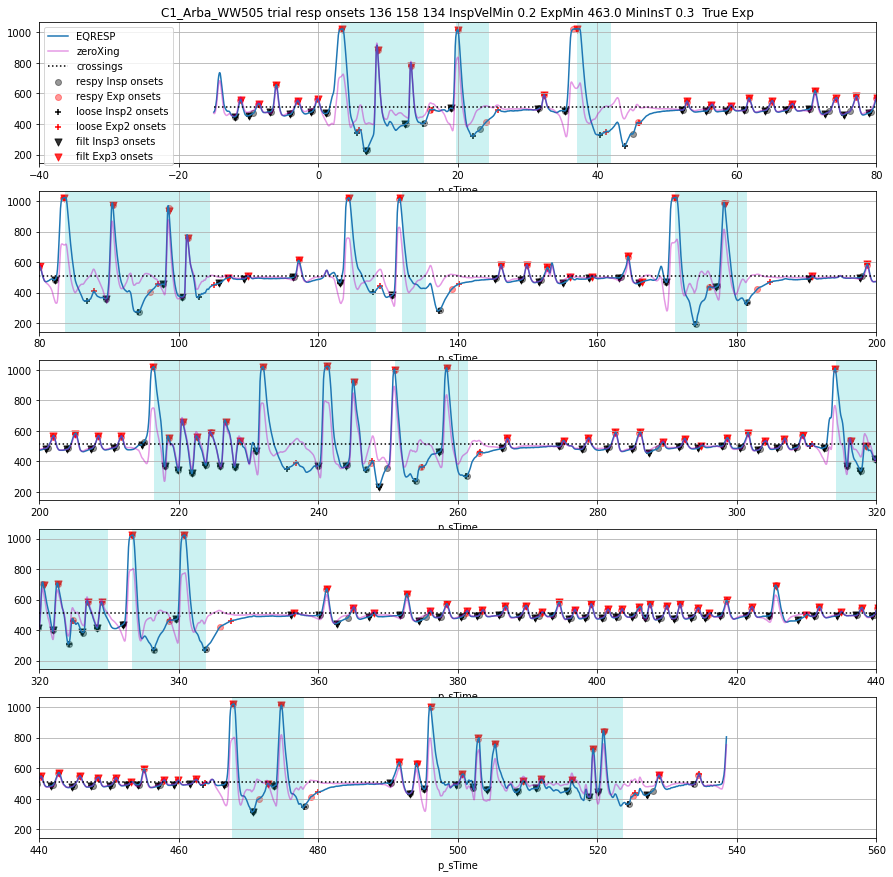

['WW505', 136, 158, 134]


In [833]:
fig, axes = plt.subplots(5,1,figsize=(15,15))

for i in range(len(axes)):
    ax = axes[i]
    R['Breathing'].plot(label = 'EQRESP',ax=ax)
    ax.plot(R.loc[:,['Breathing']] - respnormed(R['Breathing'],filtering_range = [0.2],scaling=1),'m',alpha = 0.4,label='zeroXing')
    ax.plot([-15,538],[512,512],c = 'k',linestyle = ':',label='crossings')
    
    ax.scatter(x=Breaths['In'],y = R.loc[Breaths['In'],'Breathing'],c = 'k',alpha = 0.4,label='respy Insp onsets')
    ax.scatter(x=Breaths['Ex'],y = R.loc[Breaths['Ex'],'Breathing'],c = 'r',alpha = 0.4,label='respy Exp onsets')
    ax.scatter(x=Breaths2['In'],y = R.loc[Breaths2['In'],'Breathing'],c = 'k',marker = '+',label='loose Insp2 onsets')
    ax.scatter(x=Breaths2['Ex'],y = R.loc[Breaths2['Ex'],'Breathing'],c = 'r',marker = '+',label='loose Exp2 onsets')
    ax.scatter(x=Breaths3['In'],y = R.loc[Breaths3['In'],'Breathing'],c = 'k',marker = 'v',s = 50,alpha = 0.8,label='filt Insp3 onsets')
    ax.scatter(x=Breaths3['Ex'],y = R.loc[Breaths3['Ex'],'Breathing'],c = 'r',marker = 'v',s = 50,alpha = 0.8,label='filt Exp3 onsets')
    ax.set_xlim([-40+i*120,-40+(i+1)*120])
    ax.grid()
    if i <1: ax.legend()
    eq.play_shade(ax,Pentries,concert,part)
axes[0].set_title(' '.join([sig_ex,'trial resp onsets',str(len(Breaths)),str(len(Breaths2)),str(len(Breaths3)),'InspVelMin',str(vel_c),'ExpMin',str(expMin),'MinInsT',str(minInspT),' True Exp']))
plt.savefig('_'.join(['./plots/trial',sig_ex,'InEx.jpg']),bbox_inches = 'tight',dpi = 200)
plt.show()
print([partID,len(Breaths),len(Breaths2),len(Breaths3)])

Flute breaths narrowed beautifully with selection parameters set to a very low min chest expansion criterion, 0.2 and then filtering:
 - first by expirations starting way below the resting volumn (lower quartile), 
 - then by inspirations that are too short (< 300 ms),
 - last by expirations that end above their starting depth. 
 
comparision to the performance of the respy insp extractor default (pale x) and the unfiltered values (pale dots), this inspiration and expiration selection looks representative. 

Only issue is some of the inspirations starts look to be rather early, pre elbow. 

Last issue is to correct for clipping.  current strategy kind of works but its agressive

The flute settings are a little to relaxed for the horn (603) but not bad. Performs fairly well on the 

# Compression to compensate for wonky measuremnts
It also possible to use compression to transform respiratory recoordings with extremely low values to signal that can be processedin a more consistent fashion. However, teh consequences of this kind fo transformation is a bit iffy considering the dynamic nature of the amplification/reduciong of the original signals. A given recording, if it is several minutes long, could segments recorded with different mappings, so compression on the whole signal might be too agressive, exagerating to breath scale noise that shouldn't be counted. 

So It's coded, it's possible, but the best way to implement an automated compression strategy has not yet been determined. 

The compression algo below is super super basic. A better mapping could also be determined, as well as conditions for application.

In [930]:
def resp_compress(R):
    factA = 10.0
    thrB = 100 # +/-
    factB = 0.08
    mid = 512
    K = ((R-mid)*factA)
    K[K>thrB] = thrB + (K[K>thrB]-thrB)*factB
    K[K<-thrB] = -thrB + (K[K<-thrB]+thrB)*factB
    K = K + mid
    
    return K


<Axes: xlabel='c_sTime'>

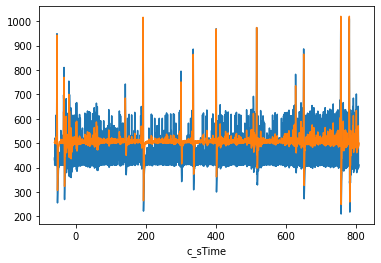

In [935]:
K = resp_compress(R['Breathing'])
K.plot()
R['Breathing'].plot()

# Testing flute settings

strings pretty consistently do beter with a higher velocity threshold 0.35, while woodwinds need lower 0.2. Otherwise, performances is pretty good either way with these secondary filtering criteria.

Some string players show a high proporotion of augmented breaths, resulting in very squeezed quiet resp signals. These should be treated with a low insp vel threshold, just like brass and winds. 

How can we detect this kind of respiratory distribtion? 
is there a signal quality that can be assess numerically and then used as a deciding factor for what threshold should be employed to assess inspirations.

    set the threshold or trigger a switch of standard from 0.35 to 0.2

In [962]:
# Building_FULL_AU819_EQRESP
partID = 'BR601' #partID = 'WW505'
piece='Arba'
concert = 'C2'
sig_ex = '_'.join([concert,piece,partID])

Score_map = pd.read_csv(data_loc+'PlayTimings - Score_parts.csv',index_col = 0)
Pentries = pd.read_csv(data_loc+'PlayTimings_'+piece+'_entries.csv') 
part = Score_map.loc[partID,piece]

R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)
R.set_index('p_sTime',drop=True,inplace=True)

vel_c = 0.35
x_hz = 0.2
minInspT = 0.4
expMin = R['Breathing'].quantile(0.25)

newResp = R.loc[:,['Breathing']].copy()
newResp['Filt'] = rp2.respnormed(R['Breathing'],scaling=1)
newResp['Diff1'] = rp2.diffed(newResp['Filt'] )
expansion_dist = newResp['Diff1'].loc[newResp['Diff1']>0].copy()*sf
print(np.round([newResp['Diff1'].std()*sf,expansion_dist.median(),expansion_dist.quantile(0.25),expansion_dist.mean()*0.35,expansion_dist.mean()*0.2,newResp['Diff1'].std()*sf/expansion_dist.median()],3))
skewstat = newResp['Diff1'].std()*sf/expansion_dist.median()
Resp = unclip_minor(R['Breathing'].copy())
if skewstat>4:
    vel_c = 0.2
else:
    vel_c = 0.35
# if skewstat>5:
#     Resp=resp_compress(Resp)

Breaths = rp.Inspiration_Extract(R['Breathing'])  
# rp.Breath_Features(R['Breathing'],scalingfactor=1,filtered=False)
Breaths2 = breath_cycles(rp2.Inspiration_Extract(Resp,False,vel_c,x_hz),R)
[len(Breaths),len(Breaths2)]

# additional filtering
Breaths3=Breaths2.copy()
# cut "breaths" that expire from well below the baseline 
thresh = expMin
Breaths3 =  breath_cycles(Breaths3.loc[Breaths3['Ex_C']>thresh,['In','Ex']].reset_index(drop = True),R)
# cutting short expirations
thresh = minInspT
B=pd.DataFrame()
J = Breaths3['Exp_T']>thresh
J.iloc[-1] = True
K = Breaths3['Exp_T'].shift(1)>thresh
K.iloc[0] = True
B.loc[:,'In']= Breaths3.loc[K,'In'].values
B.loc[:,'Ex']= Breaths3.loc[J,'Ex'].values
Breaths3 = breath_feats(B)
# cutting short inspirations
thresh = minInspT #0.25 # s
Breaths3 =  breath_cycles(Breaths3.loc[Breaths3['Insp_T']>thresh,['In','Ex']].reset_index(drop = True),R)
# cutting expirations that end with higher values than they started
thresh = 0
Breaths3 =  breath_cycles(Breaths3.loc[Breaths3['IE_DR']>thresh,['In','Ex']].reset_index(drop = True),R)
[len(Breaths),len(Breaths2),len(Breaths3)]

[131.875  17.985   5.199  20.208  11.548   7.333]
Clipped!


[134, 190, 138]

In [ ]:
[131.875  17.985   5.199  20.208  11.548   7.333]
Clipped!

[134, 186, 154]

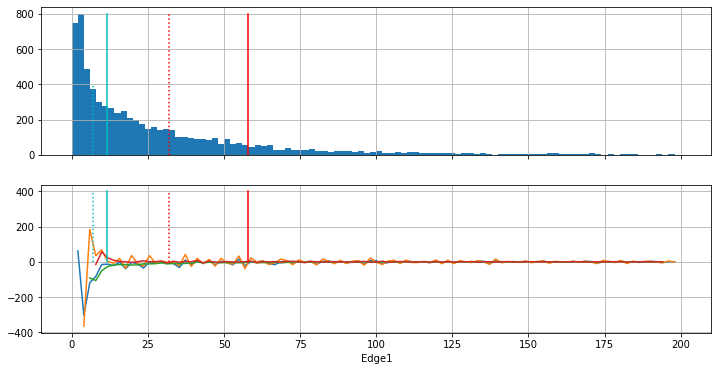

[131.875  17.985   5.199  20.208  11.548   7.333]


In [957]:
sf = 25.6
newResp = R.loc[:,['Breathing']].copy()
newResp['Filt'] = rp2.respnormed(R['Breathing'],scaling=1)
newResp['Diff1'] = rp2.diffed(newResp['Filt'] )
expansion_dist = newResp['Diff1'].loc[newResp['Diff1']>0].copy()*sf

fig, axes = plt.subplots(2,1,figsize=(12,6),sharex = True)
ax = axes[0]
expansion_dist.hist(bins=100,range=[0,200],ax=ax)
ax.plot(np.array([1,1])*expansion_dist.mean(),[0,800],'r')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.55,[0,800],'r',linestyle=':')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.2,[0,800],'c')
# InspThresh = newResp['Diff1'].loc[newResp['Diff1']>0].mean()*sf*vel_c
# VelThresh = InspThresh/sf;
ax = axes[1]
h = np.histogram(expansion_dist,bins=int(4*sf),range=[0,200])
dist = pd.DataFrame(columns =['Counts','Edge1','Edge2'])
dist['Edge1'] = h[1][:-1]
dist['Edge2'] = h[1][1:]
dist.set_index('Edge1',inplace = True,drop=False)
dist['Counts'] = h[0]
dist['Counts'].diff().plot(ax=ax)
dist['Counts'].diff().diff().plot(ax=ax)
dist['Counts'].diff().rolling(5,center=True).mean().plot(ax=ax)
dist['Counts'].diff().rolling(5,center=True).mean().diff().plot(ax=ax)
row = dist.loc[dist['Counts'].diff().diff()>0,:].iloc[0]
tent_thresh = (row['Edge1']+row['Edge2'])/2
alt_C = tent_thresh/expansion_dist.mean()
ax.plot(np.array([1,1])*expansion_dist.mean(),[0,400],'r')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.55,[0,400],'r',linestyle=':')
ax.plot(np.array([1,1])*expansion_dist.mean()*0.2,[0,400],'c')
ax.plot(np.array([1,1])*expansion_dist.mean()*alt_C,[0,400],'c',linestyle=':')
axes[0].plot(np.array([1,1])*expansion_dist.mean()*alt_C,[0,400],'c',linestyle=':')
ax.grid()
plt.show()
print(np.round([newResp['Diff1'].std()*sf,expansion_dist.median(),expansion_dist.quantile(0.25),expansion_dist.mean()*0.35,expansion_dist.mean()*0.2,newResp['Diff1'].std()*sf/expansion_dist.median()],3))


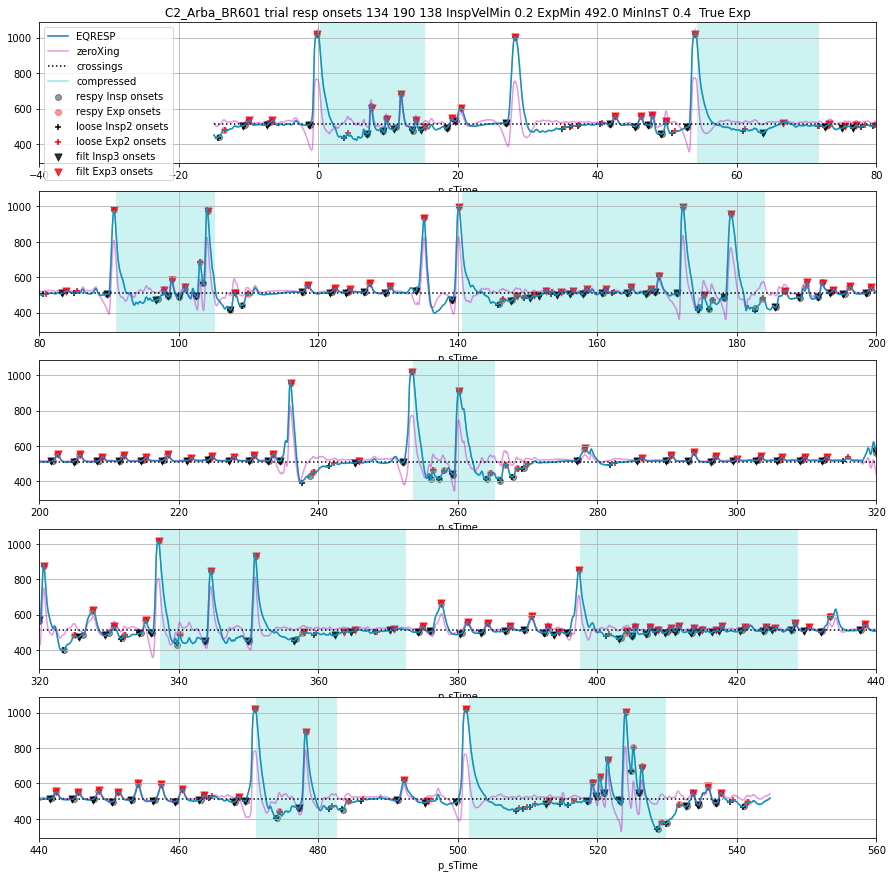

['BR601', 134, 190, 138]


In [963]:
fig, axes = plt.subplots(5,1,figsize=(15,15))

for i in range(len(axes)):
    ax = axes[i]
    R['Breathing'].plot(label = 'EQRESP',ax=ax)
    ax.plot(R.loc[:,['Breathing']] - respnormed(R['Breathing'],filtering_range = [0.2],scaling=1),'m',alpha = 0.4,label='zeroXing')
    ax.plot([-15,538],[512,512],c = 'k',linestyle = ':',label='crossings')
    Resp.plot(color='c',alpha = 0.4,label='compressed',ax=ax)

    ax.scatter(x=Breaths['In'],y = R.loc[Breaths['In'],'Breathing'],c = 'k',alpha = 0.4,label='respy Insp onsets')
    ax.scatter(x=Breaths['Ex'],y = R.loc[Breaths['Ex'],'Breathing'],c = 'r',alpha = 0.4,label='respy Exp onsets')
    ax.scatter(x=Breaths2['In'],y = R.loc[Breaths2['In'],'Breathing'],c = 'k',marker = '+',label='loose Insp2 onsets')
    ax.scatter(x=Breaths2['Ex'],y = R.loc[Breaths2['Ex'],'Breathing'],c = 'r',marker = '+',label='loose Exp2 onsets')
    ax.scatter(x=Breaths3['In'],y = R.loc[Breaths3['In'],'Breathing'],c = 'k',marker = 'v',s = 50,alpha = 0.8,label='filt Insp3 onsets')
    ax.scatter(x=Breaths3['Ex'],y = R.loc[Breaths3['Ex'],'Breathing'],c = 'r',marker = 'v',s = 50,alpha = 0.8,label='filt Exp3 onsets')
    ax.set_xlim([-40+i*120,-40+(i+1)*120])
    ax.grid()
    if i <1: ax.legend()
    eq.play_shade(ax,Pentries,concert,part)
axes[0].set_title(' '.join([sig_ex,'trial resp onsets',str(len(Breaths)),str(len(Breaths2)),str(len(Breaths3)),'InspVelMin',str(vel_c),'ExpMin',str(expMin),'MinInsT',str(minInspT),' True Exp']))
plt.savefig('_'.join(['./plots/trial',sig_ex,'InEx2.jpg']),bbox_inches = 'tight',dpi = 200)
plt.show()
print([partID,len(Breaths),len(Breaths2),len(Breaths3)])

# Testing sans play times

In [932]:
# Building_FULL_AU819_EQRESP
partID = 'AU816' #partID = 'WW505'
piece='Full'
concert = 'Linedancing'
sig_ex = '_'.join([concert,piece,partID])

R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv')
R.set_index('c_sTime',drop=True,inplace=True)

# vel_c = 0.35
x_hz = 0.2
minInspT = 0.4
expMin = R['Breathing'].quantile(0.25)

newResp = R.loc[:,['Breathing']].copy()
newResp['Filt'] = rp2.respnormed(R['Breathing'],scaling=1)
newResp['Diff1'] = rp2.diffed(newResp['Filt'] )
expansion_dist = newResp['Diff1'].loc[newResp['Diff1']>0].copy()*sf
print(np.round([newResp['Diff1'].std()*sf,expansion_dist.median(),expansion_dist.quantile(0.25),expansion_dist.mean()*0.35,expansion_dist.mean()*0.2,newResp['Diff1'].std()*sf/expansion_dist.median()],3))
skewstat = newResp['Diff1'].std()*sf/expansion_dist.median()
Resp = unclip_minor(R['Breathing'].copy())
if skewstat>5:
    Resp=resp_compress(Resp)
#     vel_c = 0.2
# else:
#     vel_c = 0.3


Breaths = rp.Inspiration_Extract(R['Breathing'])  
# rp.Breath_Features(R['Breathing'],scalingfactor=1,filtered=False)
Breaths2 = breath_cycles(rp2.Inspiration_Extract(Resp,False,vel_c,x_hz),R)
[len(Breaths),len(Breaths2)]

# additional filtering
Breaths3=Breaths2.copy()
# cut "breaths" that expire from well below the baseline 
thresh = expMin
Breaths3 =  breath_cycles(Breaths3.loc[Breaths3['Ex_C']>thresh,['In','Ex']].reset_index(drop = True),R)
# cutting short expirations
thresh = minInspT
B=pd.DataFrame()
J = Breaths3['Exp_T']>thresh
J.iloc[-1] = True
K = Breaths3['Exp_T'].shift(1)>thresh
K.iloc[0] = True
B.loc[:,'In']= Breaths3.loc[K,'In'].values
B.loc[:,'Ex']= Breaths3.loc[J,'Ex'].values
Breaths3 = breath_feats(B)
# cutting short inspirations
thresh = minInspT #0.25 # s
Breaths3 =  breath_cycles(Breaths3.loc[Breaths3['Insp_T']>thresh,['In','Ex']].reset_index(drop = True),R)
# cutting expirations that end with higher values than they started
thresh = 0
Breaths3 =  breath_cycles(Breaths3.loc[Breaths3['IE_DR']>thresh,['In','Ex']].reset_index(drop = True),R)
[len(Breaths),len(Breaths2),len(Breaths3)]

[89.965 12.554  5.93  10.973  6.27   7.166]
Clipped!


[289, 441, 408]

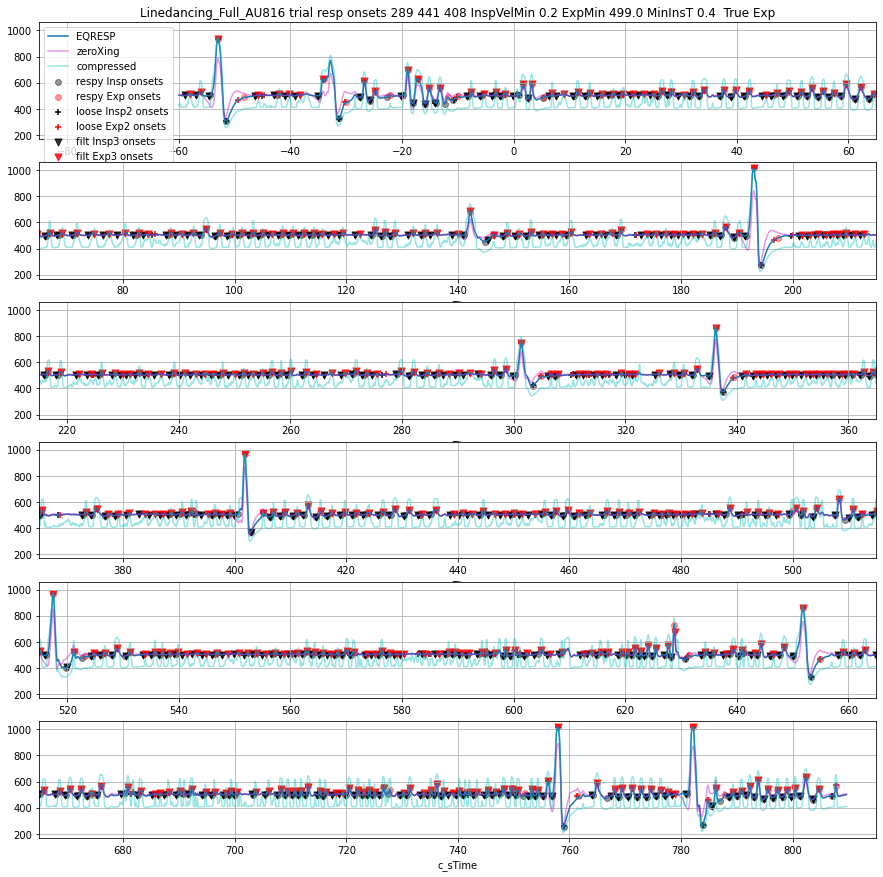

['AU816', 289, 441, 408]


In [936]:
fig, axes = plt.subplots(6,1,figsize=(15,15))
K = resp_compress(R['Breathing'])

for i in range(len(axes)):
    ax = axes[i]
    R['Breathing'].plot(label = 'EQRESP',ax=ax)
    ax.plot(R.loc[:,['Breathing']] - respnormed(R['Breathing'],filtering_range = [0.2],scaling=1),'m',alpha = 0.4,label='zeroXing')
    K.plot(color='c',alpha = 0.4,label='compressed',ax=ax)
    #     ax.plot([-15,538],[512,512],c = 'k',linestyle = ':',label='crossings')
    
    ax.scatter(x=Breaths['In'],y = R.loc[Breaths['In'],'Breathing'],c = 'k',alpha = 0.4,label='respy Insp onsets')
    ax.scatter(x=Breaths['Ex'],y = R.loc[Breaths['Ex'],'Breathing'],c = 'r',alpha = 0.4,label='respy Exp onsets')
    ax.scatter(x=Breaths2['In'],y = R.loc[Breaths2['In'],'Breathing'],c = 'k',marker = '+',label='loose Insp2 onsets')
    ax.scatter(x=Breaths2['Ex'],y = R.loc[Breaths2['Ex'],'Breathing'],c = 'r',marker = '+',label='loose Exp2 onsets')
    ax.scatter(x=Breaths3['In'],y = R.loc[Breaths3['In'],'Breathing'],c = 'k',marker = 'v',s = 50,alpha = 0.8,label='filt Insp3 onsets')
    ax.scatter(x=Breaths3['Ex'],y = R.loc[Breaths3['Ex'],'Breathing'],c = 'r',marker = 'v',s = 50,alpha = 0.8,label='filt Exp3 onsets')
    ax.set_xlim([-85+i*150,-85+(i+1)*150])
    ax.grid()
    if i <1: ax.legend()
#     eq.play_shade(ax,Pentries,concert,part)
axes[0].set_title(' '.join([sig_ex,'trial resp onsets',str(len(Breaths)),str(len(Breaths2)),str(len(Breaths3)),'InspVelMin',str(vel_c),'ExpMin',str(expMin),'MinInsT',str(minInspT),' True Exp']))
plt.savefig('_'.join(['./plots/trial',sig_ex,'InEx.jpg']),bbox_inches = 'tight',dpi = 200)
plt.show()
print([partID,len(Breaths),len(Breaths2),len(Breaths3)])

# TEST SECTION
of strings

[282.261 173.347  64.237  78.856  45.06    1.628]
['AU801', 382, 407, 387]
[124.226  54.815  18.051  31.254  17.859   2.266]
Clipped!
['AU802', 324, 357, 332]
[160.883  75.001  20.302  40.856  23.346   2.145]
Clipped!
['AU803', 310, 332, 322]
[146.085  70.649  23.029  37.283  21.305   2.068]
Clipped!
['AU804', 321, 344, 321]
[47.861 18.983  7.119  9.599  5.485  2.521]
Clipped!
['AU805blue', 353, 343, 302]
[249.345 116.661  37.514  62.892  35.938   2.137]
Clipped!
['AU806', 344, 373, 349]
[183.579  57.439  22.144  35.529  20.302   3.196]
Clipped!
['AU807', 318, 361, 345]
[156.597  59.475  19.459  35.812  20.464   2.633]
Clipped!
['AU808', 329, 376, 348]
[234.884  84.89   28.744  49.41   28.234   2.767]
Clipped!
['AU809', 358, 389, 361]
[154.027  96.814  42.275  43.069  24.611   1.591]
['AU810', 438, 472, 445]
[71.634 27.109 11.278 16.137  9.221  2.642]
['AU811', 343, 392, 339]
[72.646 16.842  7.172 11.604  6.631  4.314]
['AU812', 306, 362, 344]
[259.264 178.274  61.608  75.339  43.051  

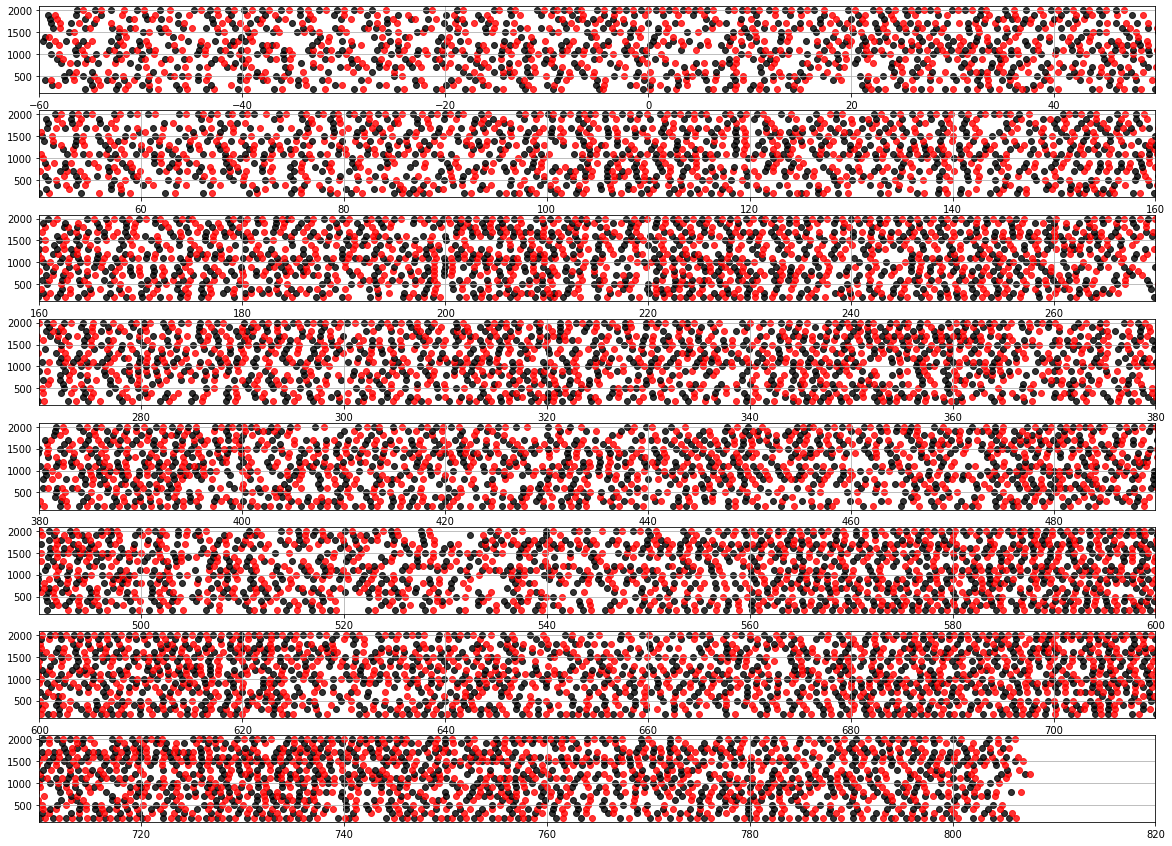

In [961]:
fig, axes = plt.subplots(8,1,figsize=(20,15))
for j in range(1,20):
    partID = 'AU'+ str(800 + j) #secID[j]
    if j == 5:
        partID = 'AU805blue'
    piece='Full'
    concert = 'Linedancing'
    sig_ex = '_'.join([concert,piece,partID])

    filename  = data_loc + sig_ex + '_EQRESP.csv'
    if os.path.isfile(filename):
        R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)
#         R.set_index('c_sTime',drop=True,inplace=True)
        Breaths = rp.Inspiration_Extract(R['Breathing']) # old selections

        newResp = R.loc[:,['Breathing']].copy()
        newResp['Filt'] = rp2.respnormed(R['Breathing'],scaling=1)
        newResp['Diff1'] = rp2.diffed(newResp['Filt'] )
        expansion_dist = newResp['Diff1'].loc[newResp['Diff1']>0].copy()*sf
        print(np.round([newResp['Diff1'].std()*sf,expansion_dist.median(),expansion_dist.quantile(0.25),expansion_dist.mean()*0.35,expansion_dist.mean()*0.2,newResp['Diff1'].std()*sf/expansion_dist.median()],3))
        skewstat = newResp['Diff1'].std()*sf/expansion_dist.median()
        Resp = unclip_minor(R['Breathing'].copy())
#         if skewstat>4:
#             vel_c = 0.2
#         else:
#             vel_c = 0.35
        if skewstat>5:
            Resp=resp_compress(Resp)

        Breaths2 = breath_cycles(rp2.Inspiration_Extract(Resp,False,vel_c,0.2),R) 

        # additional filtering
        Breaths3=Breaths2.copy()
        # cut "breaths" that expire from well below the baseline 
        thresh = R['Breathing'].quantile(0.25)
        Breaths3 =  breath_cycles(Breaths3.loc[Breaths3['Ex_C']>thresh,['In','Ex']].reset_index(drop = True),R)
        # cutting short expirations
        thresh = 0.4
        B=pd.DataFrame()
        J = Breaths3['Exp_T']>thresh
        J.iloc[-1] = True
        K = Breaths3['Exp_T'].shift(1)>thresh
        K.iloc[0] = True
        B.loc[:,'In']= Breaths3.loc[K,'In'].values
        B.loc[:,'Ex']= Breaths3.loc[J,'Ex'].values
        Breaths3 = breath_feats(B)
        # cutting short inspirations
        thresh = 0.4 #0.25 # s
        Breaths3 =  breath_cycles(Breaths3.loc[Breaths3['Insp_T']>thresh,['In','Ex']].reset_index(drop = True),R)
        # cutting expirations that end with higher values than they started
        thresh = 0
        Breaths3 =  breath_cycles(Breaths3.loc[Breaths3['IE_DR']>thresh,['In','Ex']].reset_index(drop = True),R)
        print([partID,len(Breaths),len(Breaths2),len(Breaths3)])

        for i in range(len(axes)):
            ax = axes[i]
            ax.scatter(x=Breaths3['In'],y = (j+1)*100*np.ones(len(Breaths3)),c = 'k',alpha = 0.8,label='Insp3 onsets')
            ax.scatter(x=Breaths3['Ex'],y = (j+1)*100*np.ones(len(Breaths3)),c = 'r',alpha = 0.8,label='Exp3 onsets')
#             ax.scatter(x=Breaths['In'],y = (j+1)*-100*np.ones(len(Breaths)),c = 'k',alpha = 0.4,label='Insp onsets')
#             ax.scatter(x=Breaths['Ex'],y = (j+1)*-100*np.ones(len(Breaths)),c = 'r',alpha = 0.4,label='Exp onsets')
            ax.set_xlim([-60+i*110,-60+(i+1)*110])
            ax.grid()
    #     if i <1: ax.legend()

# for i in range(len(axes)):
#     eq.play_shade(axes[i],Pentries,concert,part)
plt.savefig('_'.join(['./plots/trial',concert,'InEx.jpg']),bbox_inches = 'tight',dpi = 200)

plt.show()

[139.268  48.097  16.905  28.649  16.371   2.896]
['VN101', 161, 171, 167]
[191.254  92.966  36.772  46.13   26.36    2.057]
['VN102', 216, 226, 222]
[232.57   39.975  13.317  39.916  22.809   5.818]
Clipped!
['VN103', 136, 145, 129]
[94.273 34.581 13.247 18.98  10.846  2.726]
['VN104', 221, 238, 229]
[137.722  50.576  18.455  30.113  17.208   2.723]
['VN105', 210, 202, 197]
[95.05  37.463 10.193 21.219 12.125  2.537]
['VN107', 184, 201, 188]
[68.622 25.297  9.199 13.259  7.577  2.713]
['VN108', 197, 201, 197]


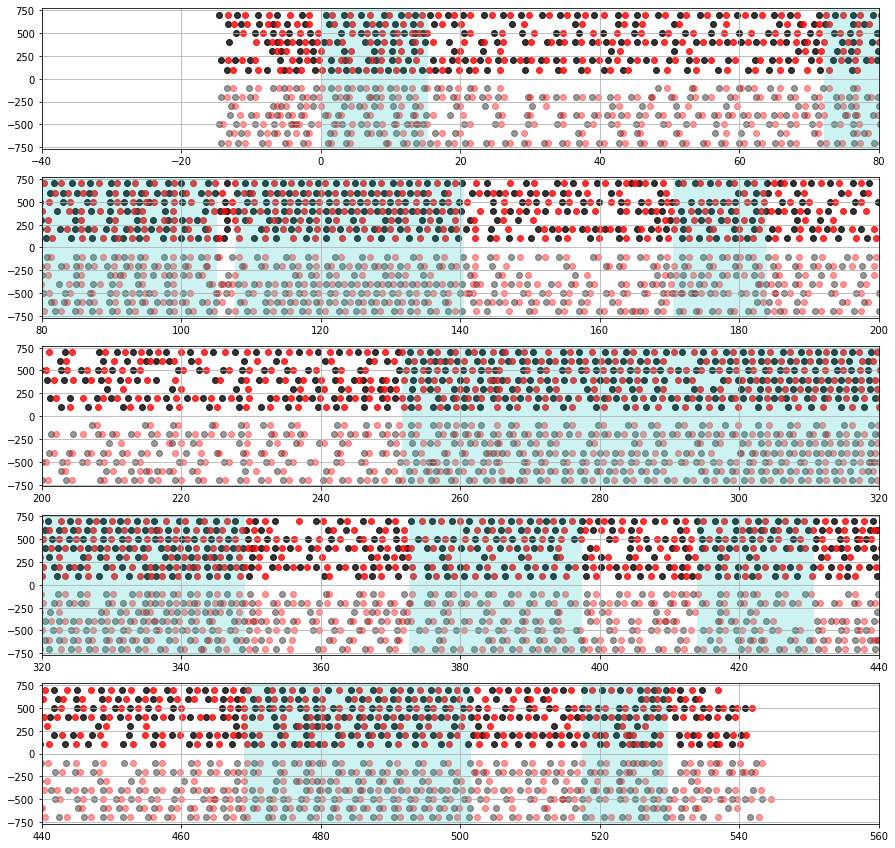

In [940]:
fig, axes = plt.subplots(5,1,figsize=(15,15))
# secID = ['VN201','VN202','VN203','VN204','VN205','VN206','VN207','VN208','VN209','VN210'] 
secID = ['VN101','VN102','VN103','VN104','VN105','VN107','VN108'] # 'VN106',
# secID = ['VA301','VA302','VA303','VA304','VA305','VA307','VA308'] # c1 c2 VA306

for j in range(len(secID)):
    partID = secID[j]
#     partID = 'VA301'
    piece='Arba'
    concert = 'C2'
    sig_ex = '_'.join([concert,piece,partID])

    Score_map = pd.read_csv(data_loc+'PlayTimings - Score_parts.csv',index_col = 0)
    Pentries = pd.read_csv(data_loc+'PlayTimings_'+piece+'_entries.csv') 
    part = Score_map.loc[partID,piece]
    
    filename  = data_loc + sig_ex + '_EQRESP.csv'
    if os.path.isfile(filename):
        R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)
        R.set_index('p_sTime',drop=True,inplace=True)
        Breaths = rp.Inspiration_Extract(R['Breathing']) # old selections

        newResp = R.loc[:,['Breathing']].copy()
        newResp['Filt'] = rp2.respnormed(R['Breathing'],scaling=1)
        newResp['Diff1'] = rp2.diffed(newResp['Filt'] )
        expansion_dist = newResp['Diff1'].loc[newResp['Diff1']>0].copy()*sf
        print(np.round([newResp['Diff1'].std()*sf,expansion_dist.median(),expansion_dist.quantile(0.25),expansion_dist.mean()*0.35,expansion_dist.mean()*0.2,newResp['Diff1'].std()*sf/expansion_dist.median()],3))
        skewstat = newResp['Diff1'].std()*sf/expansion_dist.median()
        Resp = unclip_minor(R['Breathing'].copy())
#         if skewstat>4:
#             vel_c = 0.2
#         else:
#             vel_c = 0.35
        if skewstat>5:
            Resp=resp_compress(Resp)

        Breaths2 = breath_cycles(rp2.Inspiration_Extract(Resp,False,vel_c,0.2),R) 

        # additional filtering
        Breaths3=Breaths2.copy()
        # cut "breaths" that expire from well below the baseline 
        thresh = R['Breathing'].quantile(0.25)
        Breaths3 =  breath_cycles(Breaths3.loc[Breaths3['Ex_C']>thresh,['In','Ex']].reset_index(drop = True),R)
        # cutting short expirations
        thresh = 0.4
        B=pd.DataFrame()
        J = Breaths3['Exp_T']>thresh
        J.iloc[-1] = True
        K = Breaths3['Exp_T'].shift(1)>thresh
        K.iloc[0] = True
        B.loc[:,'In']= Breaths3.loc[K,'In'].values
        B.loc[:,'Ex']= Breaths3.loc[J,'Ex'].values
        Breaths3 = breath_feats(B)
        # cutting short inspirations
        thresh = 0.4 #0.25 # s
        Breaths3 =  breath_cycles(Breaths3.loc[Breaths3['Insp_T']>thresh,['In','Ex']].reset_index(drop = True),R)
        # cutting expirations that end with higher values than they started
        thresh = 0
        Breaths3 =  breath_cycles(Breaths3.loc[Breaths3['IE_DR']>thresh,['In','Ex']].reset_index(drop = True),R)
        print([partID,len(Breaths),len(Breaths2),len(Breaths3)])



        for i in range(len(axes)):
            ax = axes[i]
            ax.scatter(x=Breaths3['In'],y = (j+1)*100*np.ones(len(Breaths3)),c = 'k',alpha = 0.8,label='Insp3 onsets')
            ax.scatter(x=Breaths3['Ex'],y = (j+1)*100*np.ones(len(Breaths3)),c = 'r',alpha = 0.8,label='Exp3 onsets')
            ax.scatter(x=Breaths['In'],y = (j+1)*-100*np.ones(len(Breaths)),c = 'k',alpha = 0.4,label='Insp onsets')
            ax.scatter(x=Breaths['Ex'],y = (j+1)*-100*np.ones(len(Breaths)),c = 'r',alpha = 0.4,label='Exp onsets')

            ax.set_xlim([-40+i*120,-40+(i+1)*120])
            ax.grid()
    #     if i <1: ax.legend()

for i in range(len(axes)):
    eq.play_shade(axes[i],Pentries,concert,part)
plt.show()

In [ ]:
[112.204  32.587  10.614  20.701  11.829   3.443]
Clipped!
['VA301', 182, 187, 179]
[153.847  60.634  21.283  32.486  18.564   2.537]
['VA302', 190, 189, 186]
[65.402 10.117  3.871  8.516  4.866  6.465]
['VA303', 148, 197, 174]
[47.693 20.415  7.7   11.211  6.406  2.336]
['VA304', 212, 228, 197]
[88.404 33.35  13.713 20.238 11.565  2.651]
['VA305', 167, 181, 163]
[139.619  52.886  22.09   29.265  16.723   2.64 ]
Clipped!
['VA306', 172, 174, 172]
[70.202 16.694  6.472 12.946  7.398  4.205]
['VA308', 145, 165, 149]

[112.204  32.587  10.614  20.701  11.829   3.443]
Clipped!
['VA301', 182, 187, 179]
[141.947  75.889  25.171  34.443  19.682   1.87 ]
['VA302', 202, 205, 197]
[71.776 14.189  6.254 10.594  6.054  5.059]
Clipped!
['VA303', 173, 205, 189]
[45.543 17.695  6.523 10.38   5.932  2.574]
['VA304', 220, 234, 201]
[93.976 37.25  15.235 21.095 12.054  2.523]
['VA305', 168, 180, 161]
[0.696 0.297 0.125 0.146 0.083 2.345]
Clipped!
['VA306', 288, 300, 128]
[52.176 17.613  6.995 10.27   5.868  2.962]
['VA308', 176, 184, 165]
